In [ ]:
#!/usr/bin/env python3

import os
from random import randint, random

import h5py
import numpy as np
from PIL import Image, ImageDraw


def generate(dir_name, num_imgs):
    # `torchvision.datasets.ImageFolder` requires a subfolder
    os.makedirs(f'./msds2/{dir_name}/0', exist_ok=True)

    labels = np.empty((num_imgs, 4, 4, 6), dtype=np.int32)
    for count in range(num_imgs):
        item_angle = random() * 180

        img = Image.new('RGB', (32, 32), (0, 0, 0))
        for i in range(4):
            for j in range(4):
                item = Image.new('RGBA', (8, 8), (255, 255, 255, 0))
                draw = ImageDraw.Draw(item)

                now_color = (
                    randint(0, 255),
                    randint(0, 255),
                    randint(0, 255),
                    255,
                )
                draw.ellipse((1, 3, 7, 5), now_color)
                now_angle = item_angle + random() * 45
                item = item.rotate(now_angle,
                                   resample=Image.Resampling.BICUBIC)

                now_pos = (
                    i * 8 + randint(-1, 1),
                    j * 8 + randint(-1, 1),
                )
                img.paste(item, now_pos, mask=item)

                label = now_pos + (now_angle, ) + now_color[:3]
                labels[count, i, j, :] = label

        img.save(f'./msds2/{dir_name}/0/{count:05d}.png', compress_level=1)

    with h5py.File(f'./msds2/{dir_name}_labels.hdf5', 'w') as f:
        f.create_dataset('labels',
                         data=labels,
                         compression='gzip',
                         shuffle=True)


def main():
    generate('train', 9 * 10**4)
    generate('test', 10**4)


if __name__ == '__main__':
    main()


In [ ]:
# msds1_dataset.py
import os
from pathlib import Path
from typing import Tuple, Optional, Callable

import h5py
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset

batch_size = 512

class MSDS2(Dataset):
    """
    Minimal PyTorch-style wrapper around the dataset generated by your script.

    • Each sample returns:
        img   –   torch.Tensor   (C, H, W)   –   by default in [0,1]
        label –   torch.Tensor   (4, 4, 6)   –   (x, y, angle, R, G, B)
    """

    def __init__(
        self,
        root: str | Path = "./msds1",
        split: str = "train",            # "train" | "test"
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        preload_labels: bool = True,     # load the entire HDF5 once; fine for 90k × 96 ints ≈ 35 MB
    ):
        super().__init__()

        split = split.lower()
        if split not in {"train", "test"}:
            raise ValueError(f"split must be 'train' or 'test', got {split!r}")

        self.img_dir = Path(root) / split / "0"
        self.img_paths = sorted(self.img_dir.glob("*.png"))          # 00000.png, 00001.png, …
        if not self.img_paths:
            raise FileNotFoundError(f"No images found in {self.img_dir}")

        # ------ labels ------------------------------------------------------
        h5_path = Path(root) / f"{split}_labels.hdf5"
        if not h5_path.exists():
            raise FileNotFoundError(h5_path)

        if preload_labels:
            with h5py.File(h5_path, "r") as f:
                self.labels = torch.from_numpy(f["labels"][...])     # (N, 4, 4, 6)
        else:
            # keep only the path; open lazily in __getitem__
            self.labels = None
            self._h5_path = h5_path

        # ------ optional transforms ----------------------------------------
        from torchvision.transforms import ToTensor
        self.transform = transform or ToTensor()
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_paths)

    # --------------------------------------------------------------------- #
    def _lazy_load_label(self, idx: int) -> torch.Tensor:
        """Open the HDF5 file every time (safer with num_workers>0)."""
        with h5py.File(self._h5_path, "r") as f:
            arr = f["labels"][idx]                   # (4, 4, 6) ndarray
        return torch.from_numpy(arr)

    # --------------------------------------------------------------------- #
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # --- image ---------------------------------------------------------
        img = Image.open(self.img_paths[idx]).convert("RGB")         # (32×32)
        if self.transform:
            img = self.transform(img)                                # torch.FloatTensor

        # --- label ---------------------------------------------------------
        if self.labels is not None:                                  # pre-loaded
            target = self.labels[idx]
        else:                                                        # lazy path
            target = self._lazy_load_label(idx)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target


In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

# -- transforms --------------------------------------------------------------
transforms = Compose([
    ToTensor()                         # PIL → [0,1] tenso
])

# -- datasets & loaders ------------------------------------------------------
train_ds = MSDS2(root="./msds2", split="train", transform=transforms)
test_ds  = MSDS2(root="./msds2", split="test",  transform=transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

# ---- quick sanity check ----------------------------------------------------
images, labels = next(iter(train_loader))
print(images.shape)   # torch.Size([128, 3, 32, 32])
print(labels.shape)   # torch.Size([128, 4, 4, 6])


torch.Size([512, 3, 32, 32])
torch.Size([512, 4, 4, 6])


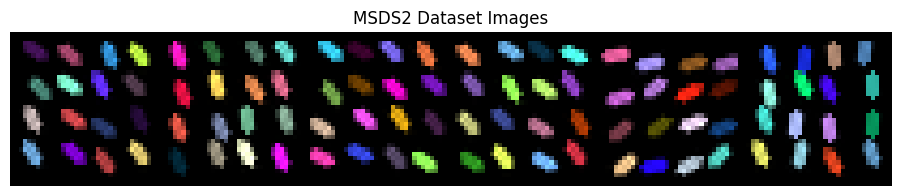

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_images(data_loader, num_images: int = 6, *, denorm=None):
    """
    Visualise `num_images` images from the first batch in `data_loader`.

    Args
    ----
    data_loader : torch.utils.data.DataLoader
        Your existing loader (train or val).
    num_images  : int
        How many images from the batch to plot (<= batch_size).
    denorm : callable or None
        Optionally reverse any normalisation applied in your transforms.
        Example:
            denorm = lambda x: x * 0.5 + 0.5        # if you used Normalize(mean=.5, std=.5)
    """
    # Grab one batch; no need to exhaust the iterator
    images, labels = next(iter(data_loader))       # labels ignored for plotting
    images = images[:num_images].cpu()

    if denorm is not None:
        images = denorm(images)

    # torchvision.utils.make_grid puts them into one canvas
    grid = torchvision.utils.make_grid(
        images, nrow=num_images, padding=2, normalize=False
    )
    grid = grid.permute(1, 2, 0).numpy()           # (C,H,W) → (H,W,C) for matplotlib

    plt.figure(figsize=(2 * num_images, 2))
    plt.imshow(grid)
    plt.title(f"MSDS2 Dataset Images")
    plt.axis("off")
    plt.show()
show_images(train_loader)

In [ ]:
from torch.nn import init
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.distributions as D
import os
from torch.nn.utils.parametrizations import weight_norm
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from contextlib import nullcontext # Used to conditionally disable the profiler
from torch.utils.checkpoint import checkpoint
from math import sqrt, log
from typing import List, Tuple, Dict, Any, Optional, Union
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision('high')

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from math import sqrt


class Swish(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)


class ResNet(nn.Module):
    def __init__(self, nres = 4, widths = [48, 512, 512, 48], final_scale = True):
        assert widths[0] == widths[-1]

        super().__init__()
        self.res_blocks = nn.ModuleList(
            [self.build_res_block(widths) for _ in range(nres)])

        if final_scale:
            self.scale = nn.Parameter(torch.zeros(widths[-1]))
        else:
            self.scale = None

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        bound = sqrt(2.81 * 3 / in_features)
        nn.init.uniform_(linear.weight, -bound, bound)
        nn.init.zeros_(linear.bias)
        linear = weight_norm(linear)
        return linear

    def build_res_block(self, widths):
        layers = []
        for i in range(len(widths) - 1):
            layers.append(Swish(widths[i]))
            layers.append(self.build_linear(widths[i], widths[i + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        for res_block in self.res_blocks:
            x = (x + res_block(x)) / sqrt(2)

        if self.scale is not None:
            x = x * self.scale

        return x


class ResidualNetwork(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        shape = x.shape  # (B*num_RG_blocks, C, K, K)
        x = x.view(shape[0], -1)  # (B*num_RG_blocks, C*K*K)
        x = super().forward(x)
        x = x.view(shape)
        return x

In [ ]:
def create_masks(kernel_size: int, num_channels:int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Create checkerboard masks for the RNVP block.
    Args:
        kernel_size: The size of the kernel
        num_channels: The number of channels in the input
    Returns:
        mask: The mask for the networks
        comask: The complementary mask such that mask + comask = 1
    '''
    checkerboard = torch.from_numpy(np.indices((kernel_size, kernel_size)).sum(axis=0) % 2).float()
    mask = checkerboard.unsqueeze(0).repeat(num_channels, 1, 1)
    comask = 1 - mask
    return mask, comask

class RNVPBlock(nn.Module):
    mask: torch.Tensor
    comask: torch.Tensor

    def __init__(
        self,
        kernel_size: int,
        num_channels: int,
        s_nets: List[nn.Module],
        t_nets: List[nn.Module],
        *,
        apply_tanh: bool = True,
        use_ckpt: bool  = True,
    ):
        super().__init__()
        assert len(s_nets) == len(t_nets), "Need the same number of s and t networks"
        self.s_nets  = nn.ModuleList(s_nets)
        self.t_nets  = nn.ModuleList(t_nets)
        self.apply_tanh = apply_tanh
        self.use_ckpt   = use_ckpt

        mask, comask = create_masks(kernel_size, num_channels)
        self.register_buffer("mask",   mask)        # (C,H,W)
        self.register_buffer("comask", comask)


    def _checkpoint(self, fn, x):
        if self.training and self.use_ckpt and x.requires_grad:
            return checkpoint(fn, x, use_reentrant=False)   # saves memory
        else:
            return fn(x)

    def _one_forward_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 1: mask -> comask
        s1 = self.comask * self._checkpoint(s_net, x1)
        t1 = self.comask * self._checkpoint(t_net, x1)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * (torch.exp(s1) * x2 + t1)
        ldj  = s1.sum(dim=(1, 2, 3))

        # step 2: comask -> mask
        s2 = self.mask * self._checkpoint(s_net, x2_)
        t2 = self.mask * self._checkpoint(t_net, x2_)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * (torch.exp(s2) * x1 + t2)
        ldj += s2.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def _one_inverse_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 2⁻¹
        s2 = self.mask * self._checkpoint(s_net, x2)
        t2 = self.mask * self._checkpoint(t_net, x2)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * torch.exp(-s2) * (x1 - t2)
        ldj  = -s2.sum(dim=(1, 2, 3))

        # step 1⁻¹
        s1 = self.comask * self._checkpoint(s_net, x1_)
        t1 = self.comask * self._checkpoint(t_net, x1_)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * torch.exp(-s1) * (x2 - t1)
        ldj -= s1.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def forward(self, x):
        ldj = torch.zeros(x.size(0), device=x.device)
        for s_net, t_net in zip(self.s_nets, self.t_nets):
            x, inc = self._one_forward_flow(x, s_net, t_net)
            ldj += inc
        return x, ldj

    def inverse(self, z):
        ldj = torch.zeros(z.size(0), device=z.device)
        for s_net, t_net in zip(reversed(self.s_nets), reversed(self.t_nets)):
            z, inc = self._one_inverse_flow(z, s_net, t_net)
            ldj += inc
        return z, ldj


In [ ]:
def shift_kernel_blocks(x: torch.Tensor, m: int, h:int, inverse : bool = False) -> torch.Tensor:
    shift = (m // 2) * (2 ** h)
    if not inverse:
        return torch.roll(x, shifts=(-shift, -shift), dims=(-2, -1))
    else:
        return torch.roll(x, shifts=(shift, shift), dims=(-2, -1))

class MERABlock(nn.Module):
    def __init__(self, m, h, network, shift=False):
        super().__init__()
        self.m = m
        self.h = h
        self.network = network # Should have forward and inverse methods
        self.dilation = 2 ** h
        self.stride = m * self.dilation
        self.unfold = nn.Unfold(kernel_size=m, dilation=self.dilation, stride=self.stride)
        self.fold = None
        self.shift = shift
        self.cached_mask = None

    def _apply_flow(self, x, flow_method):
        B, C, H, W = x.shape

        x_orig = x
        x_to_process = x
        if self.shift:
            x_to_process = shift_kernel_blocks(x, self.m, self.h)

        patches = self.unfold(x_to_process)

        num_patches = patches.shape[-1]
        patches_reshaped = patches.view(B, C, self.m, self.m, num_patches).permute(0, 4, 1, 2, 3).reshape(B * num_patches, C, self.m, self.m)

        # Apply the specified flow method (forward or inverse)
        transformed_patches, ldj = flow_method(patches_reshaped)

        transformed_patches_reshaped = transformed_patches.view(B, num_patches, C, self.m, self.m).permute(0, 2, 3, 4, 1).reshape(B, C * self.m * self.m, num_patches)

        if self.fold is None:
            self.fold = nn.Fold(output_size=(H, W), kernel_size=self.m, dilation=self.dilation, stride=self.stride)
            with torch.no_grad():
                single_item_patches = patches.narrow(0, 0, 1)
                self.cached_mask = self.fold(torch.ones_like(single_item_patches))

        folded = self.fold(transformed_patches_reshaped)

        mask = self.cached_mask.expand(B, C, H, W)

        if self.shift:
            folded = shift_kernel_blocks(folded, self.m, self.h, inverse=True)
            mask = shift_kernel_blocks(mask, self.m, self.h, inverse=True)

        x_updated = torch.where(mask.bool(), folded, x_orig)

        return x_updated, ldj.view(B, -1).sum(dim=1)

    def forward(self, x):
        return self._apply_flow(x, self.network.forward)

    def inverse(self, x):
        return self._apply_flow(x, self.network.inverse)

class RG_Flow(nn.Module):
    """A full MERA model built from a sequence of MERABlock layers."""
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in self.layers:
            x, ldj_ = layer.forward(x)
            ldj += ldj_
        return x, ldj

    def inverse(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in reversed(self.layers):
            x, ldj_ = layer.inverse(x)
            ldj += ldj_
        return x, ldj

In [ ]:
class PriorDistribution(nn.Module):
    def __init__(self, dist_type='laplace'):
        super().__init__()
        if dist_type == 'laplace':
            self.base_dist = D.Laplace
        elif dist_type == 'gaussian':
            self.base_dist = D.Normal
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    def __repr__(self):
        return f"PriorDistribution(dist_type={self.base_dist.__name__})"

    def log_prob(self, z, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros_like(z), scale=torch.ones_like(z) * temperature)
        return dist.log_prob(z).sum(dim=[1, 2, 3]) # Sum over all dimensions except batch

    def sample(self, shape, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros(shape), scale=torch.ones(shape) * temperature)
        return dist.sample()

In [ ]:
n_layers = [4, 4, 4, 4, 4, 4, 4, 4]

layers = []
for n in n_layers:
    s_nets = [ResidualNetwork() for _ in range(n)]
    t_nets = [ResidualNetwork() for _ in range(n)]
    layers.append(RNVPBlock(kernel_size=4, num_channels=3, s_nets=s_nets, t_nets=t_nets, apply_tanh=True, use_ckpt=True))

MERA_layers = []
for i, layer in enumerate(layers):
    MERA_layers.append(
        MERABlock(m=4, h = i // 2, network=layer, shift=(i % 2 == 1))
    )
flow = RG_Flow(MERA_layers)
flow.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


RG_Flow(
  (layers): ModuleList(
    (0-1): 2 x MERABlock(
      (network): RNVPBlock(
        (s_nets): ModuleList(
          (0-3): 4 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_features=512, out_features=48, bias=True)
              )
            )
          )
        )
        (t_nets): ModuleList(
          (0-3): 4 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_fea

In [ ]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        x = 1 / (1 + torch.exp(-logit_x))
        x *= 2
        x -= 1
        x /= constraint
        x += 1
        x /= 2
        return x, ldj

    else:
        if dequant:
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256
        x *= 2
        x -= 1
        x *= constraint
        x += 1
        x /= 2
        logit_x = torch.log(x) - torch.log(1 - x)
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) - F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)

        return logit_x, ldj

In [ ]:
def generate_and_show_images(
    model: RG_Flow,
    prior: PriorDistribution,
    epoch: int,
    num_images: int,
    image_dims: tuple,
    device: str,
    save_dir: str = "generated_images"
):
    """
    Generates images from the model, displays them, and saves them to a file.

    Args:
        model: The RG_Flow model instance.
        prior: The prior distribution.
        epoch: The current epoch number (for titling and saving).
        num_images: The number of images to generate.
        image_dims: A tuple of (channels, height, width).
        device: The device to run generation on.
        save_dir: Directory to save the generated images.
    """

    model.eval()


    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():

        n_channels, height, width = image_dims
        z_shape = (num_images, n_channels, height, width)
        z = prior.sample(z_shape).to(device)

        generated_logits, _ = model.inverse(z)

        generated_images, _ = logit_transform(generated_logits, dequant=False, inverse=True)

        generated_images = generated_images.cpu()
        generated_images = torch.clamp(generated_images, 0, 1)

    grid = torchvision.utils.make_grid(generated_images, nrow=int(sqrt(num_images)))
    img_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid)
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.axis('off')

    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}.png"))
    plt.show()


    model.train()

In [ ]:
import logging
import time
from datetime import datetime

def setup_logger(name='rg_flow_training'):
    """
    Sets up a logger that writes to a file and the console.
    """

    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    logger.propagate = False

    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')


    log_filename = f"training_run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
    file_handler = logging.FileHandler(log_filename)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(stream_handler)

    return logger

In [ ]:
def train_rg_flow(
    model: RG_Flow,
    prior: PriorDistribution,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: str,
    image_dims: tuple,
    logger: logging.Logger,
    num_images_to_generate: int = 16
):
    """
    The main training loop for the RG-Flow model.
    ... (args documentation) ...
    Args:
        logger: A configured logger object.
    """
    model.train()
    model.to(device)
    prior.to(device)

    n_channels, height, width = image_dims
    bpd_factor = np.log(2) * n_channels * height * width
    logger.info(f"Training for {num_epochs} epochs...")
    logger.info(f"Batch size: {BATCH_SIZE}")
    logger.info(f"Learning rate: {LEARNING_RATE}")
    logger.info(f"Image dimensions: {image_dims}")
    logger.info(f"Number of images to generate: {num_images_to_generate}")
    logger.info(prior)

    logger.info("--- Starting Training ---")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0.0

        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            x, ldj_logit = logit_transform(x)
            z_final, ldj_combined = model.forward(x)
            logp_prior = prior.log_prob(z_final)
            total_log_likelihood = logp_prior + ldj_combined + ldj_logit
            loss = -torch.mean(total_log_likelihood)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 50 == 0: # Log less frequently for a cleaner file
                bpd = (loss.item() + np.log(256.) * (n_channels * height * width)) / bpd_factor
                logger.info(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss (NLL): {loss.item():.4f} | BPD: {bpd:.4f}")

        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        logger.info(f"--- Epoch {epoch+1} Summary ---")
        logger.info(f"Average Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

        logger.info("Generating sample images...")
        generate_and_show_images(
            model=model,
            prior=prior,
            epoch=epoch,
            num_images=num_images_to_generate,
            image_dims=image_dims,
            device=device
        )

        logger.info("-" * 30)

2025-07-07 16:53:11 - INFO - Training for 60 epochs...
2025-07-07 16:53:11 - INFO - Batch size: 512
2025-07-07 16:53:11 - INFO - Learning rate: 0.001
2025-07-07 16:53:11 - INFO - Image dimensions: (3, 32, 32)
2025-07-07 16:53:11 - INFO - Number of images to generate: 16
2025-07-07 16:53:11 - INFO - PriorDistribution(dist_type=Normal)
2025-07-07 16:53:11 - INFO - --- Starting Training ---
2025-07-07 16:53:15 - INFO - Epoch: 1/60 | Batch: 0/176 | Loss (NLL): 4676.5371 | BPD: 10.1962
2025-07-07 16:54:54 - INFO - Epoch: 1/60 | Batch: 50/176 | Loss (NLL): -4461.8950 | BPD: 5.9046
2025-07-07 16:56:32 - INFO - Epoch: 1/60 | Batch: 100/176 | Loss (NLL): -6403.0674 | BPD: 4.9929
2025-07-07 16:58:11 - INFO - Epoch: 1/60 | Batch: 150/176 | Loss (NLL): -6788.9673 | BPD: 4.8117
2025-07-07 16:59:00 - INFO - --- Epoch 1 Summary ---
2025-07-07 16:59:00 - INFO - Average Loss: 122004404.3581 | Time: 349.09s
2025-07-07 16:59:00 - INFO - Generating sample images...


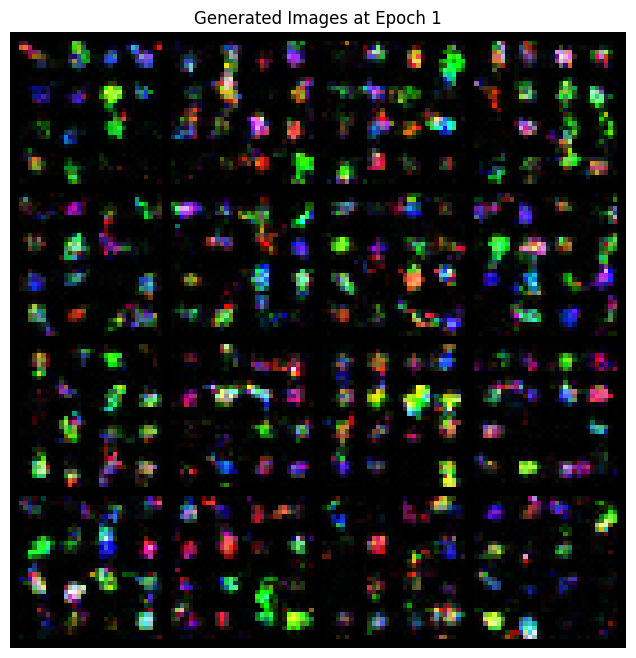

2025-07-07 16:59:00 - INFO - ------------------------------
2025-07-07 16:59:03 - INFO - Epoch: 2/60 | Batch: 0/176 | Loss (NLL): -7241.2544 | BPD: 4.5993
2025-07-07 17:00:42 - INFO - Epoch: 2/60 | Batch: 50/176 | Loss (NLL): -8004.9961 | BPD: 4.2406
2025-07-07 17:02:20 - INFO - Epoch: 2/60 | Batch: 100/176 | Loss (NLL): -8416.4297 | BPD: 4.0474
2025-07-07 17:04:00 - INFO - Epoch: 2/60 | Batch: 150/176 | Loss (NLL): -8790.8672 | BPD: 3.8716
2025-07-07 17:04:49 - INFO - --- Epoch 2 Summary ---
2025-07-07 17:04:49 - INFO - Average Loss: -8096.5878 | Time: 348.46s
2025-07-07 17:04:49 - INFO - Generating sample images...


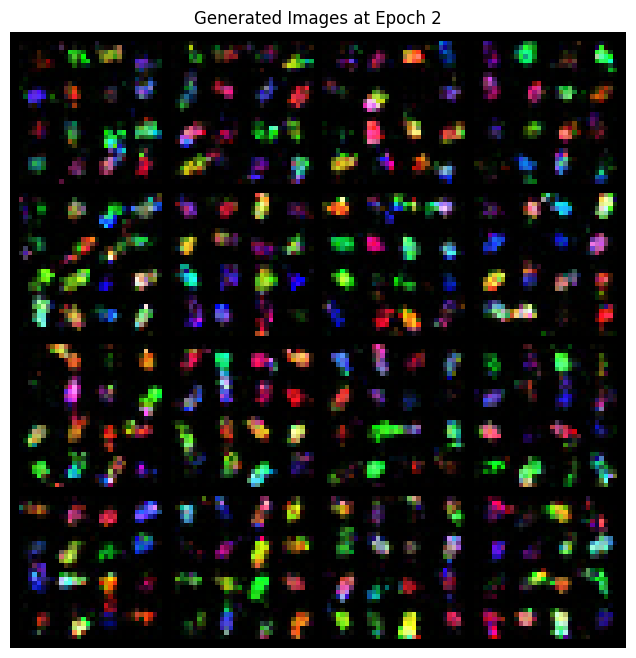

2025-07-07 17:04:49 - INFO - ------------------------------
2025-07-07 17:04:52 - INFO - Epoch: 3/60 | Batch: 0/176 | Loss (NLL): -8605.3125 | BPD: 3.9587
2025-07-07 17:06:31 - INFO - Epoch: 3/60 | Batch: 50/176 | Loss (NLL): -9194.7998 | BPD: 3.6819
2025-07-07 17:08:10 - INFO - Epoch: 3/60 | Batch: 100/176 | Loss (NLL): -9259.9854 | BPD: 3.6513
2025-07-07 17:09:50 - INFO - Epoch: 3/60 | Batch: 150/176 | Loss (NLL): -9317.3477 | BPD: 3.6243
2025-07-07 17:10:41 - INFO - --- Epoch 3 Summary ---
2025-07-07 17:10:41 - INFO - Average Loss: -9126.9244 | Time: 351.01s
2025-07-07 17:10:41 - INFO - Generating sample images...


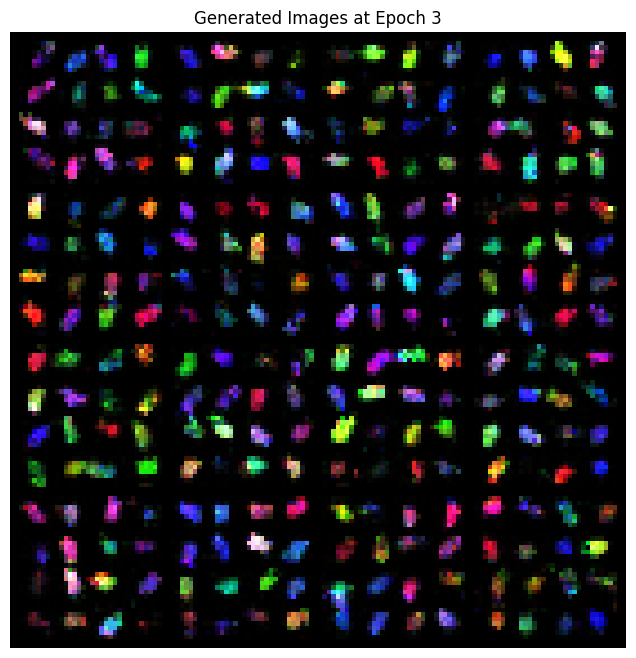

2025-07-07 17:10:41 - INFO - ------------------------------
2025-07-07 17:10:44 - INFO - Epoch: 4/60 | Batch: 0/176 | Loss (NLL): -9559.3359 | BPD: 3.5107
2025-07-07 17:12:24 - INFO - Epoch: 4/60 | Batch: 50/176 | Loss (NLL): -9405.6182 | BPD: 3.5829
2025-07-07 17:14:05 - INFO - Epoch: 4/60 | Batch: 100/176 | Loss (NLL): -9617.1016 | BPD: 3.4835
2025-07-07 17:15:44 - INFO - Epoch: 4/60 | Batch: 150/176 | Loss (NLL): -9796.2441 | BPD: 3.3994
2025-07-07 17:16:34 - INFO - --- Epoch 4 Summary ---
2025-07-07 17:16:34 - INFO - Average Loss: -9603.9163 | Time: 352.95s
2025-07-07 17:16:34 - INFO - Generating sample images...


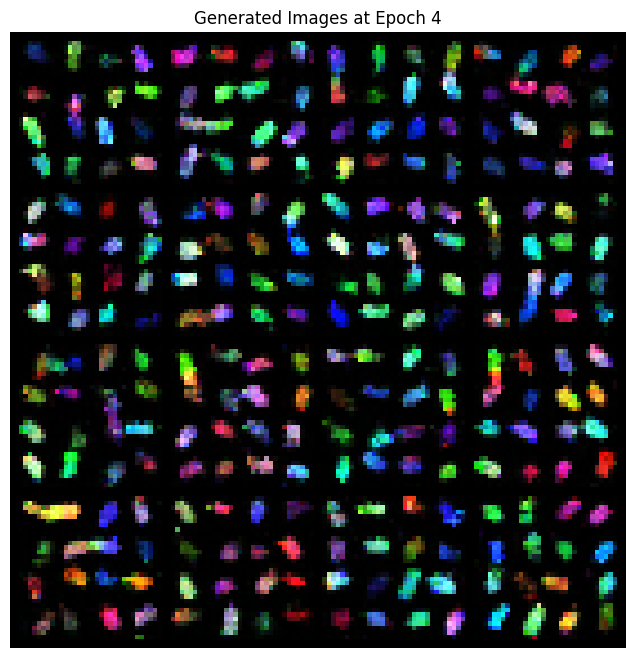

2025-07-07 17:16:34 - INFO - ------------------------------
2025-07-07 17:16:38 - INFO - Epoch: 5/60 | Batch: 0/176 | Loss (NLL): -10006.5518 | BPD: 3.3007
2025-07-07 17:18:17 - INFO - Epoch: 5/60 | Batch: 50/176 | Loss (NLL): -9942.8008 | BPD: 3.3306
2025-07-07 17:19:57 - INFO - Epoch: 5/60 | Batch: 100/176 | Loss (NLL): -10052.4414 | BPD: 3.2791
2025-07-07 17:21:36 - INFO - Epoch: 5/60 | Batch: 150/176 | Loss (NLL): -10015.6445 | BPD: 3.2964
2025-07-07 17:22:26 - INFO - --- Epoch 5 Summary ---
2025-07-07 17:22:26 - INFO - Average Loss: -9969.5851 | Time: 351.61s
2025-07-07 17:22:26 - INFO - Generating sample images...


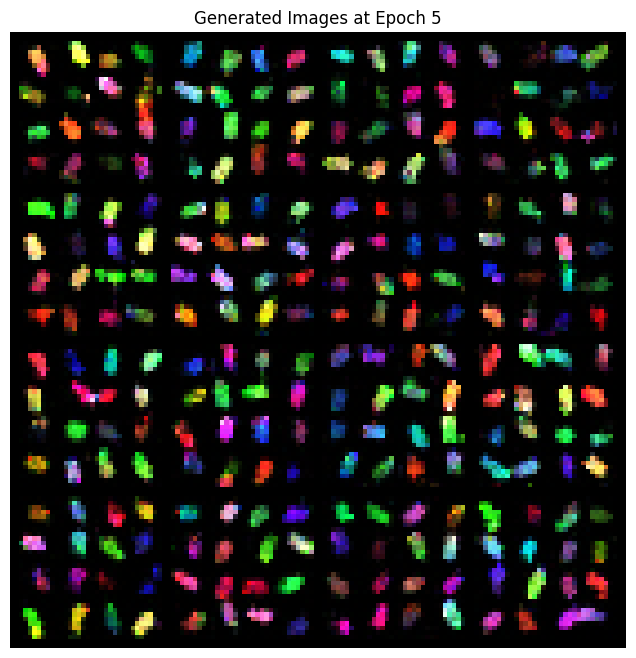

2025-07-07 17:22:27 - INFO - ------------------------------
2025-07-07 17:22:29 - INFO - Epoch: 6/60 | Batch: 0/176 | Loss (NLL): -10170.6328 | BPD: 3.2236
2025-07-07 17:24:08 - INFO - Epoch: 6/60 | Batch: 50/176 | Loss (NLL): -10137.8555 | BPD: 3.2390
2025-07-07 17:25:47 - INFO - Epoch: 6/60 | Batch: 100/176 | Loss (NLL): -10465.4082 | BPD: 3.0852
2025-07-07 17:27:27 - INFO - Epoch: 6/60 | Batch: 150/176 | Loss (NLL): -10019.6133 | BPD: 3.2945
2025-07-07 17:28:17 - INFO - --- Epoch 6 Summary ---
2025-07-07 17:28:17 - INFO - Average Loss: -10212.0586 | Time: 350.16s
2025-07-07 17:28:17 - INFO - Generating sample images...


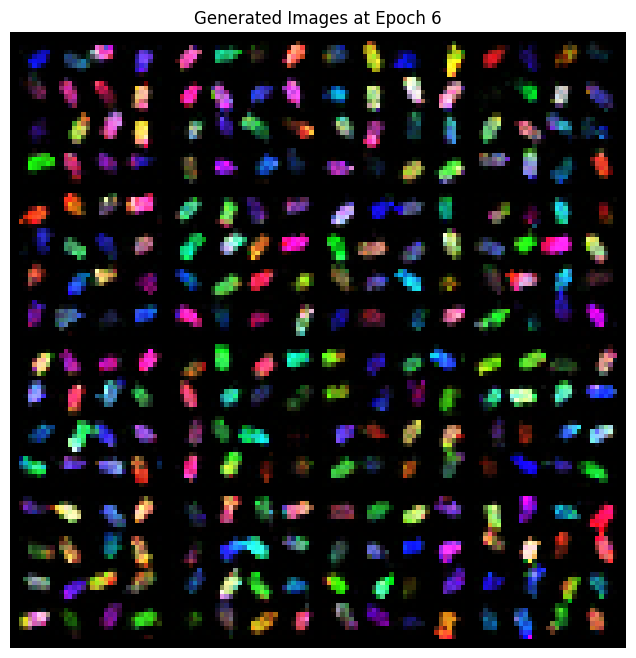

2025-07-07 17:28:17 - INFO - ------------------------------
2025-07-07 17:28:20 - INFO - Epoch: 7/60 | Batch: 0/176 | Loss (NLL): -10268.8613 | BPD: 3.1775
2025-07-07 17:29:59 - INFO - Epoch: 7/60 | Batch: 50/176 | Loss (NLL): -10510.8105 | BPD: 3.0638
2025-07-07 17:31:38 - INFO - Epoch: 7/60 | Batch: 100/176 | Loss (NLL): -9992.5352 | BPD: 3.3072
2025-07-07 17:33:17 - INFO - Epoch: 7/60 | Batch: 150/176 | Loss (NLL): -10285.8789 | BPD: 3.1695
2025-07-07 17:34:07 - INFO - --- Epoch 7 Summary ---
2025-07-07 17:34:07 - INFO - Average Loss: -10424.2115 | Time: 349.24s
2025-07-07 17:34:07 - INFO - Generating sample images...


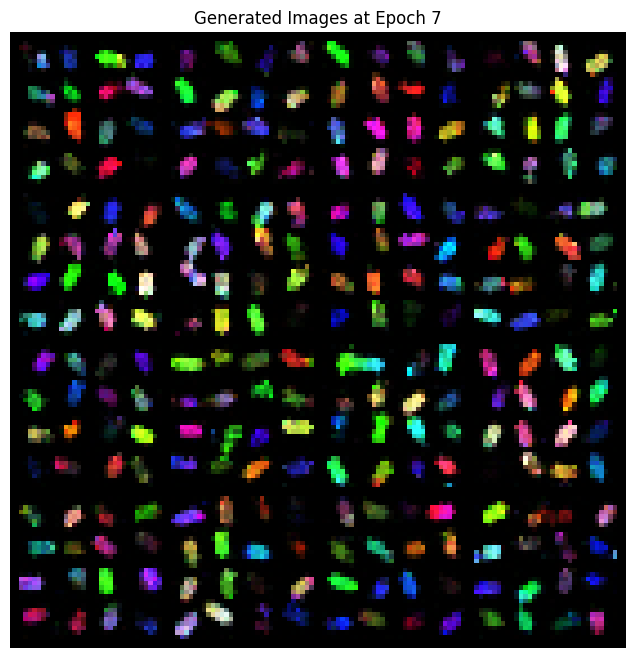

2025-07-07 17:34:07 - INFO - ------------------------------
2025-07-07 17:34:10 - INFO - Epoch: 8/60 | Batch: 0/176 | Loss (NLL): -10552.3994 | BPD: 3.0443
2025-07-07 17:35:49 - INFO - Epoch: 8/60 | Batch: 50/176 | Loss (NLL): -10718.4648 | BPD: 2.9663
2025-07-07 17:37:29 - INFO - Epoch: 8/60 | Batch: 100/176 | Loss (NLL): -10696.2441 | BPD: 2.9768
2025-07-07 17:39:09 - INFO - Epoch: 8/60 | Batch: 150/176 | Loss (NLL): -10732.6865 | BPD: 2.9596
2025-07-07 17:39:58 - INFO - --- Epoch 8 Summary ---
2025-07-07 17:39:58 - INFO - Average Loss: -10650.9456 | Time: 351.42s
2025-07-07 17:39:58 - INFO - Generating sample images...


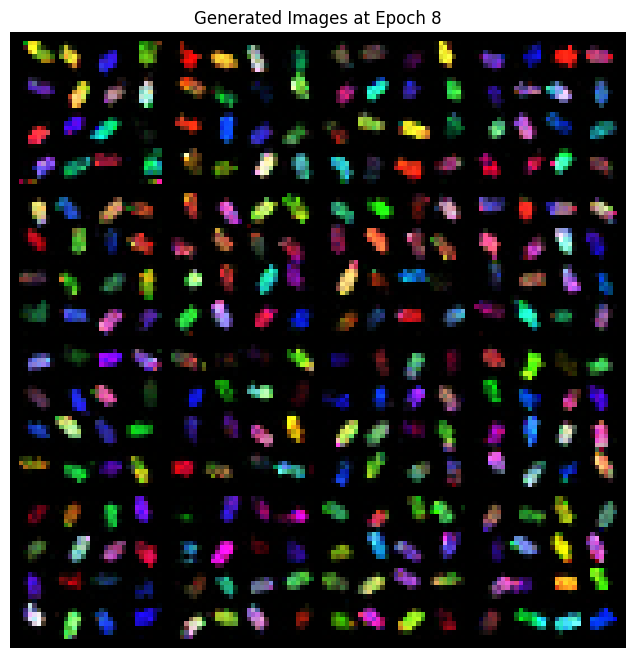

2025-07-07 17:39:59 - INFO - ------------------------------
2025-07-07 17:40:02 - INFO - Epoch: 9/60 | Batch: 0/176 | Loss (NLL): -10740.2793 | BPD: 2.9561
2025-07-07 17:41:41 - INFO - Epoch: 9/60 | Batch: 50/176 | Loss (NLL): -10838.4053 | BPD: 2.9100
2025-07-07 17:43:20 - INFO - Epoch: 9/60 | Batch: 100/176 | Loss (NLL): -10880.6387 | BPD: 2.8902
2025-07-07 17:45:00 - INFO - Epoch: 9/60 | Batch: 150/176 | Loss (NLL): -11107.5840 | BPD: 2.7836
2025-07-07 17:45:50 - INFO - --- Epoch 9 Summary ---
2025-07-07 17:45:50 - INFO - Average Loss: -10829.1293 | Time: 351.10s
2025-07-07 17:45:50 - INFO - Generating sample images...


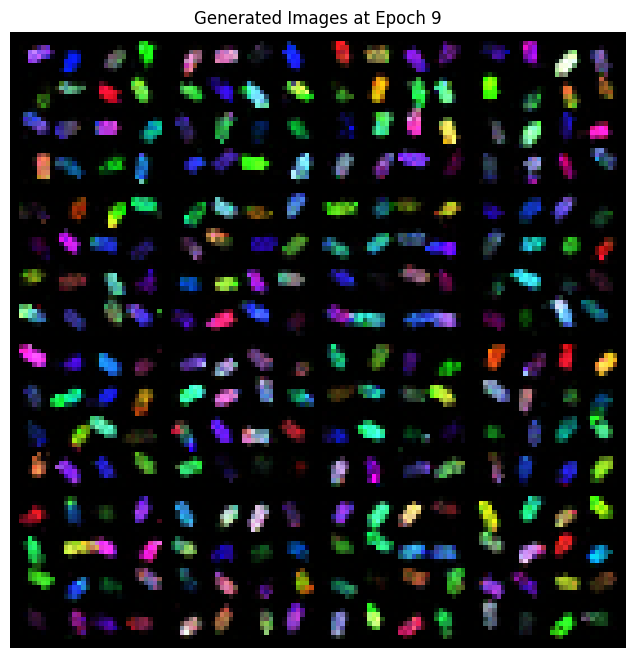

2025-07-07 17:45:50 - INFO - ------------------------------
2025-07-07 17:45:53 - INFO - Epoch: 10/60 | Batch: 0/176 | Loss (NLL): -10868.3262 | BPD: 2.8959
2025-07-07 17:47:32 - INFO - Epoch: 10/60 | Batch: 50/176 | Loss (NLL): -11049.0664 | BPD: 2.8111
2025-07-07 17:49:11 - INFO - Epoch: 10/60 | Batch: 100/176 | Loss (NLL): -10947.4609 | BPD: 2.8588
2025-07-07 17:50:49 - INFO - Epoch: 10/60 | Batch: 150/176 | Loss (NLL): -11067.9551 | BPD: 2.8022
2025-07-07 17:51:38 - INFO - --- Epoch 10 Summary ---
2025-07-07 17:51:38 - INFO - Average Loss: -10959.7961 | Time: 347.58s
2025-07-07 17:51:38 - INFO - Generating sample images...


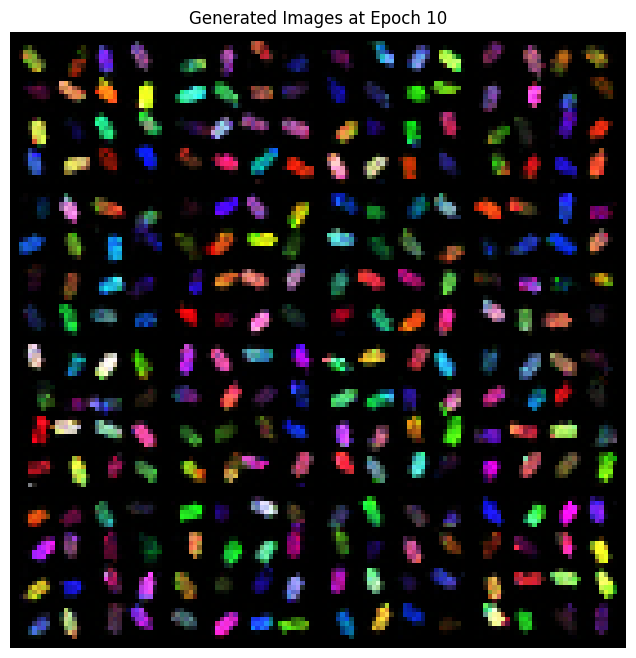

2025-07-07 17:51:38 - INFO - ------------------------------
2025-07-07 17:51:41 - INFO - Epoch: 11/60 | Batch: 0/176 | Loss (NLL): -11008.4736 | BPD: 2.8301
2025-07-07 17:53:20 - INFO - Epoch: 11/60 | Batch: 50/176 | Loss (NLL): -10527.6875 | BPD: 3.0559
2025-07-07 17:54:58 - INFO - Epoch: 11/60 | Batch: 100/176 | Loss (NLL): -10929.1055 | BPD: 2.8674
2025-07-07 17:56:37 - INFO - Epoch: 11/60 | Batch: 150/176 | Loss (NLL): -11170.9453 | BPD: 2.7538
2025-07-07 17:57:26 - INFO - --- Epoch 11 Summary ---
2025-07-07 17:57:26 - INFO - Average Loss: -10993.6976 | Time: 347.39s
2025-07-07 17:57:26 - INFO - Generating sample images...


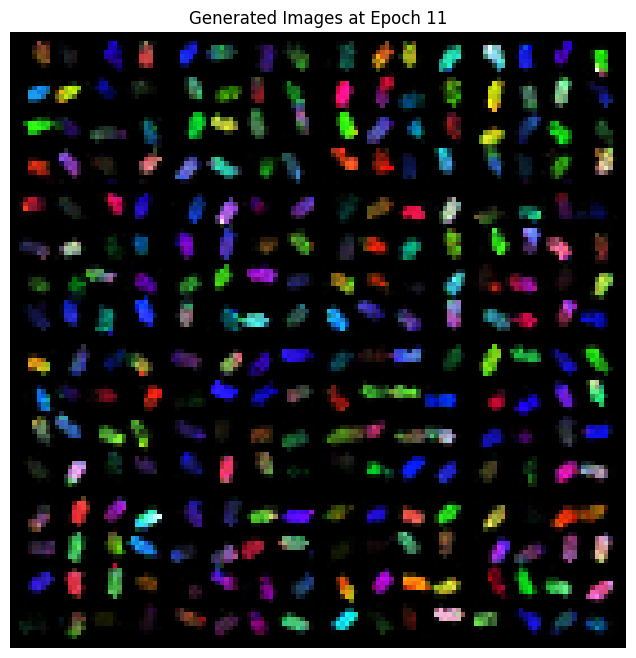

2025-07-07 17:57:26 - INFO - ------------------------------
2025-07-07 17:57:29 - INFO - Epoch: 12/60 | Batch: 0/176 | Loss (NLL): -11013.0645 | BPD: 2.8280
2025-07-07 17:59:09 - INFO - Epoch: 12/60 | Batch: 50/176 | Loss (NLL): -11142.1719 | BPD: 2.7673
2025-07-07 18:00:48 - INFO - Epoch: 12/60 | Batch: 100/176 | Loss (NLL): -11301.0459 | BPD: 2.6927
2025-07-07 18:02:29 - INFO - Epoch: 12/60 | Batch: 150/176 | Loss (NLL): -11279.2158 | BPD: 2.7030
2025-07-07 18:03:18 - INFO - --- Epoch 12 Summary ---
2025-07-07 18:03:18 - INFO - Average Loss: -11178.7735 | Time: 351.73s
2025-07-07 18:03:18 - INFO - Generating sample images...


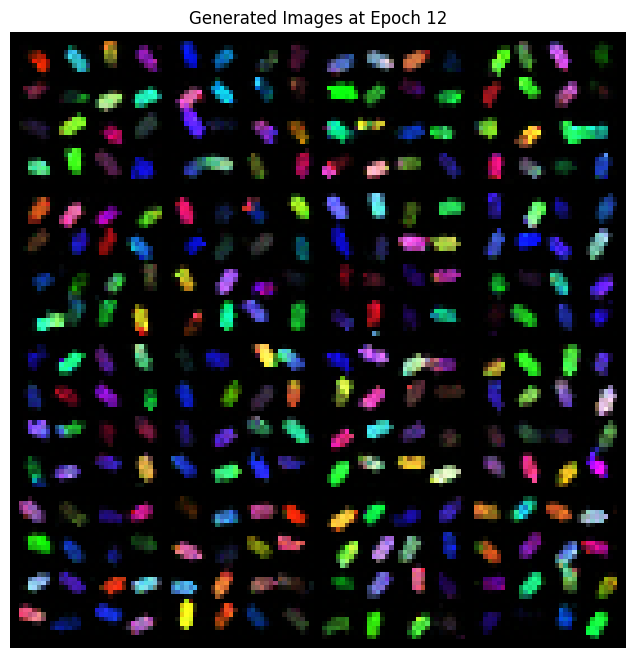

2025-07-07 18:03:19 - INFO - ------------------------------
2025-07-07 18:03:21 - INFO - Epoch: 13/60 | Batch: 0/176 | Loss (NLL): -11466.2656 | BPD: 2.6151
2025-07-07 18:05:01 - INFO - Epoch: 13/60 | Batch: 50/176 | Loss (NLL): -11540.4287 | BPD: 2.5803
2025-07-07 18:06:41 - INFO - Epoch: 13/60 | Batch: 100/176 | Loss (NLL): -11134.9590 | BPD: 2.7707
2025-07-07 18:08:20 - INFO - Epoch: 13/60 | Batch: 150/176 | Loss (NLL): -11142.4121 | BPD: 2.7672
2025-07-07 18:09:10 - INFO - --- Epoch 13 Summary ---
2025-07-07 18:09:10 - INFO - Average Loss: -11259.5760 | Time: 351.41s
2025-07-07 18:09:10 - INFO - Generating sample images...


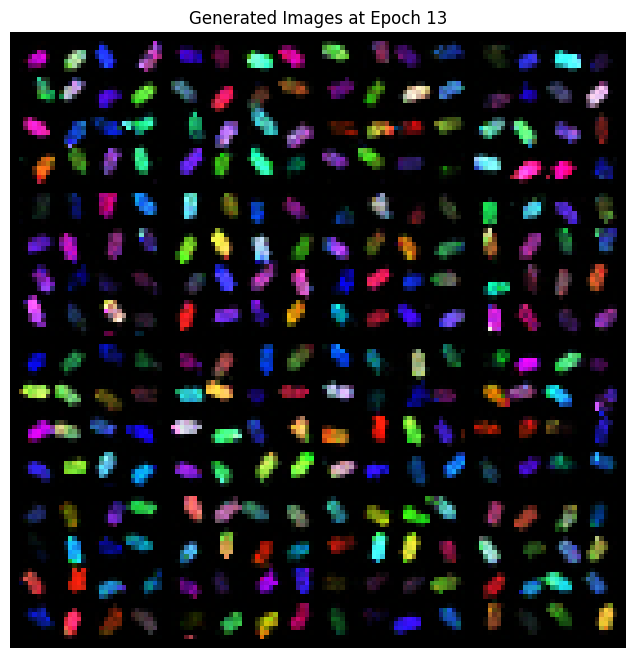

2025-07-07 18:09:11 - INFO - ------------------------------
2025-07-07 18:09:13 - INFO - Epoch: 14/60 | Batch: 0/176 | Loss (NLL): -10967.5762 | BPD: 2.8493
2025-07-07 18:10:52 - INFO - Epoch: 14/60 | Batch: 50/176 | Loss (NLL): -11491.4648 | BPD: 2.6033
2025-07-07 18:12:30 - INFO - Epoch: 14/60 | Batch: 100/176 | Loss (NLL): -11075.0332 | BPD: 2.7989
2025-07-07 18:14:07 - INFO - Epoch: 14/60 | Batch: 150/176 | Loss (NLL): -11403.9531 | BPD: 2.6444
2025-07-07 18:14:56 - INFO - --- Epoch 14 Summary ---
2025-07-07 18:14:56 - INFO - Average Loss: -11284.5868 | Time: 345.17s
2025-07-07 18:14:56 - INFO - Generating sample images...


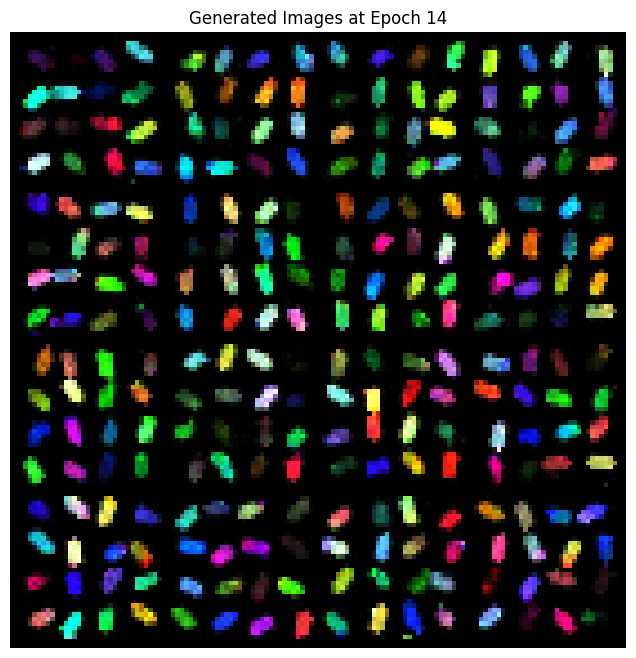

2025-07-07 18:14:56 - INFO - ------------------------------
2025-07-07 18:14:59 - INFO - Epoch: 15/60 | Batch: 0/176 | Loss (NLL): -11222.0977 | BPD: 2.7298
2025-07-07 18:16:37 - INFO - Epoch: 15/60 | Batch: 50/176 | Loss (NLL): -11413.0625 | BPD: 2.6401
2025-07-07 18:18:14 - INFO - Epoch: 15/60 | Batch: 100/176 | Loss (NLL): -11537.1348 | BPD: 2.5818
2025-07-07 18:19:52 - INFO - Epoch: 15/60 | Batch: 150/176 | Loss (NLL): -11423.0059 | BPD: 2.6354
2025-07-07 18:20:41 - INFO - --- Epoch 15 Summary ---
2025-07-07 18:20:41 - INFO - Average Loss: -11412.2754 | Time: 344.54s
2025-07-07 18:20:41 - INFO - Generating sample images...


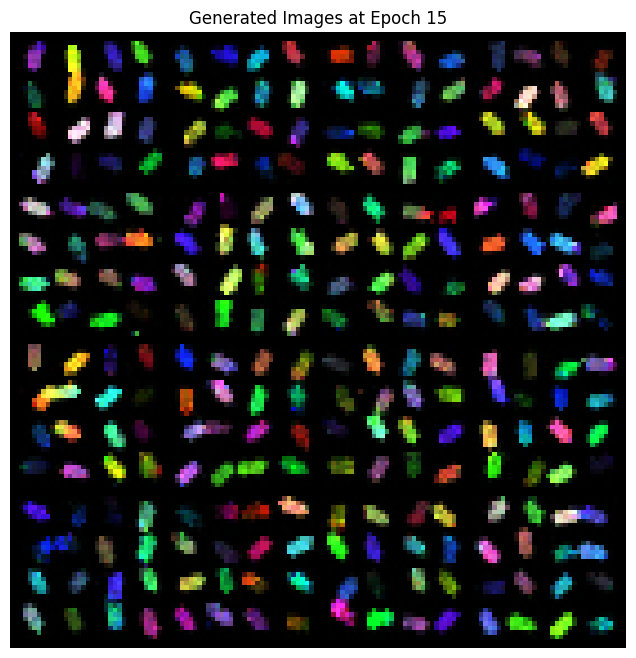

2025-07-07 18:20:41 - INFO - ------------------------------
2025-07-07 18:20:44 - INFO - Epoch: 16/60 | Batch: 0/176 | Loss (NLL): -11504.1426 | BPD: 2.5973
2025-07-07 18:22:23 - INFO - Epoch: 16/60 | Batch: 50/176 | Loss (NLL): -11560.2520 | BPD: 2.5710
2025-07-07 18:24:02 - INFO - Epoch: 16/60 | Batch: 100/176 | Loss (NLL): -11281.5439 | BPD: 2.7019
2025-07-07 18:25:41 - INFO - Epoch: 16/60 | Batch: 150/176 | Loss (NLL): -11172.1270 | BPD: 2.7533
2025-07-07 18:26:30 - INFO - --- Epoch 16 Summary ---
2025-07-07 18:26:30 - INFO - Average Loss: -11458.2885 | Time: 348.46s
2025-07-07 18:26:30 - INFO - Generating sample images...


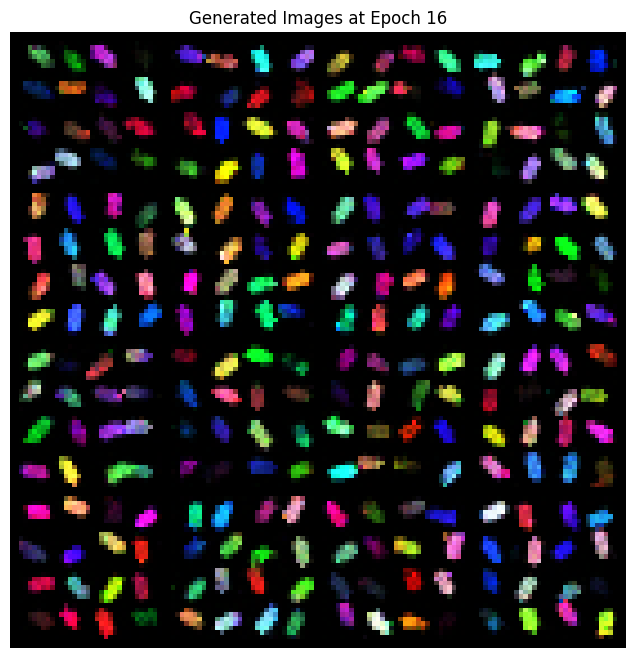

2025-07-07 18:26:30 - INFO - ------------------------------
2025-07-07 18:26:33 - INFO - Epoch: 17/60 | Batch: 0/176 | Loss (NLL): -11241.3193 | BPD: 2.7208
2025-07-07 18:28:10 - INFO - Epoch: 17/60 | Batch: 50/176 | Loss (NLL): -11466.8691 | BPD: 2.6148
2025-07-07 18:29:48 - INFO - Epoch: 17/60 | Batch: 100/176 | Loss (NLL): -11684.5547 | BPD: 2.5126
2025-07-07 18:31:26 - INFO - Epoch: 17/60 | Batch: 150/176 | Loss (NLL): -11694.2109 | BPD: 2.5081
2025-07-07 18:32:15 - INFO - --- Epoch 17 Summary ---
2025-07-07 18:32:15 - INFO - Average Loss: -11589.4835 | Time: 345.22s
2025-07-07 18:32:15 - INFO - Generating sample images...


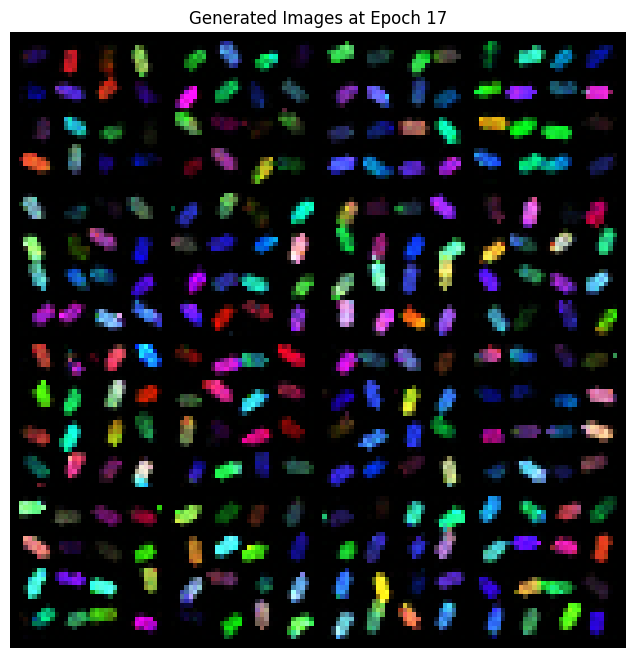

2025-07-07 18:32:16 - INFO - ------------------------------
2025-07-07 18:32:19 - INFO - Epoch: 18/60 | Batch: 0/176 | Loss (NLL): -11774.1016 | BPD: 2.4706
2025-07-07 18:33:58 - INFO - Epoch: 18/60 | Batch: 50/176 | Loss (NLL): -11517.2148 | BPD: 2.5912
2025-07-07 18:35:36 - INFO - Epoch: 18/60 | Batch: 100/176 | Loss (NLL): -11677.8398 | BPD: 2.5158
2025-07-07 18:37:13 - INFO - Epoch: 18/60 | Batch: 150/176 | Loss (NLL): -11944.0117 | BPD: 2.3908
2025-07-07 18:38:01 - INFO - --- Epoch 18 Summary ---
2025-07-07 18:38:01 - INFO - Average Loss: -11686.8884 | Time: 345.64s
2025-07-07 18:38:01 - INFO - Generating sample images...


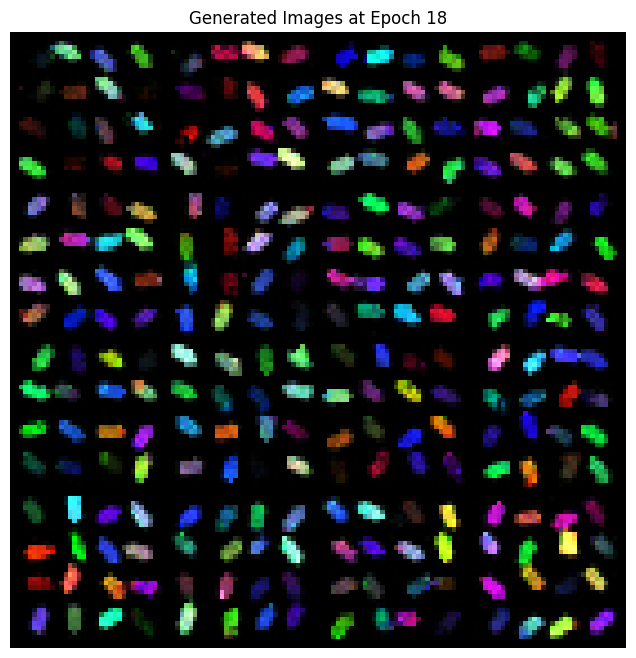

2025-07-07 18:38:02 - INFO - ------------------------------
2025-07-07 18:38:05 - INFO - Epoch: 19/60 | Batch: 0/176 | Loss (NLL): -11750.0557 | BPD: 2.4819
2025-07-07 18:39:42 - INFO - Epoch: 19/60 | Batch: 50/176 | Loss (NLL): -11455.9277 | BPD: 2.6200
2025-07-07 18:41:19 - INFO - Epoch: 19/60 | Batch: 100/176 | Loss (NLL): -11709.5049 | BPD: 2.5009
2025-07-07 18:42:56 - INFO - Epoch: 19/60 | Batch: 150/176 | Loss (NLL): -11876.2715 | BPD: 2.4226
2025-07-07 18:43:44 - INFO - --- Epoch 19 Summary ---
2025-07-07 18:43:44 - INFO - Average Loss: -11726.4741 | Time: 342.19s
2025-07-07 18:43:44 - INFO - Generating sample images...


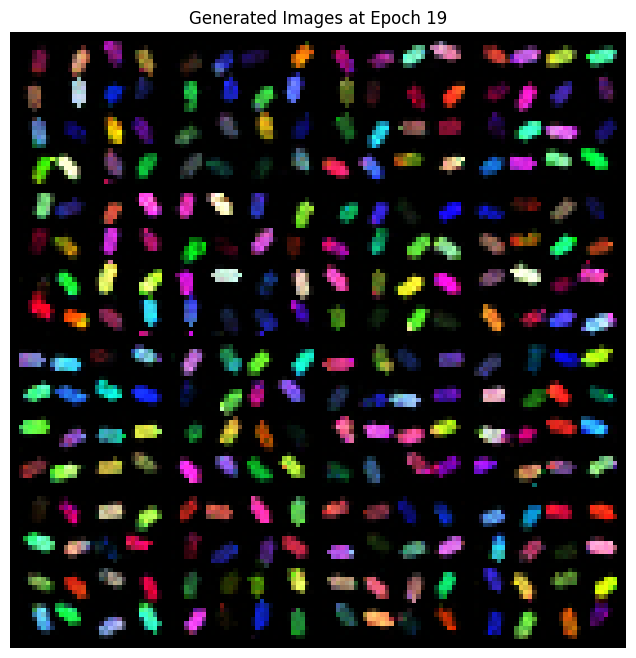

2025-07-07 18:43:45 - INFO - ------------------------------
2025-07-07 18:43:47 - INFO - Epoch: 20/60 | Batch: 0/176 | Loss (NLL): -11794.2891 | BPD: 2.4611
2025-07-07 18:45:25 - INFO - Epoch: 20/60 | Batch: 50/176 | Loss (NLL): -11859.2207 | BPD: 2.4306
2025-07-07 18:47:03 - INFO - Epoch: 20/60 | Batch: 100/176 | Loss (NLL): -12067.8809 | BPD: 2.3326
2025-07-07 18:48:41 - INFO - Epoch: 20/60 | Batch: 150/176 | Loss (NLL): -11853.7510 | BPD: 2.4332
2025-07-07 18:49:30 - INFO - --- Epoch 20 Summary ---
2025-07-07 18:49:30 - INFO - Average Loss: -11804.7131 | Time: 345.10s
2025-07-07 18:49:30 - INFO - Generating sample images...


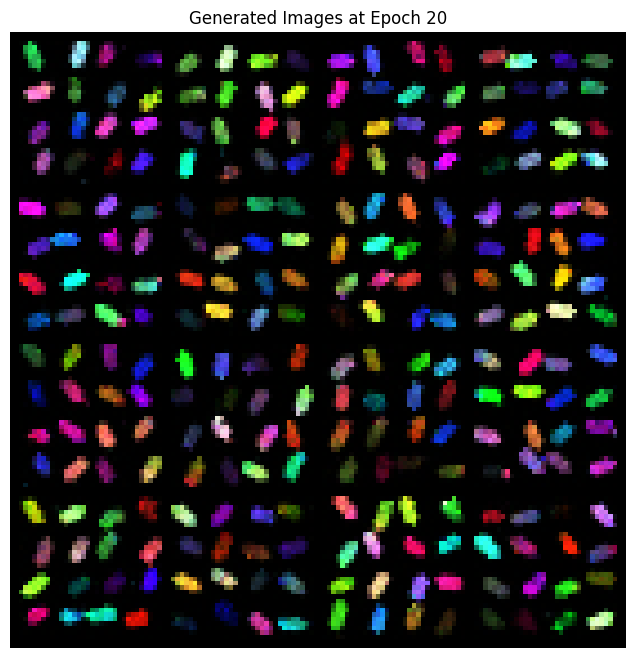

2025-07-07 18:49:30 - INFO - ------------------------------
2025-07-07 18:49:33 - INFO - Epoch: 21/60 | Batch: 0/176 | Loss (NLL): -11794.5625 | BPD: 2.4610
2025-07-07 18:51:11 - INFO - Epoch: 21/60 | Batch: 50/176 | Loss (NLL): -12164.0479 | BPD: 2.2874
2025-07-07 18:52:50 - INFO - Epoch: 21/60 | Batch: 100/176 | Loss (NLL): -11825.1426 | BPD: 2.4466
2025-07-07 18:54:29 - INFO - Epoch: 21/60 | Batch: 150/176 | Loss (NLL): -11960.2168 | BPD: 2.3832
2025-07-07 18:55:18 - INFO - --- Epoch 21 Summary ---
2025-07-07 18:55:18 - INFO - Average Loss: -11843.4997 | Time: 348.28s
2025-07-07 18:55:18 - INFO - Generating sample images...


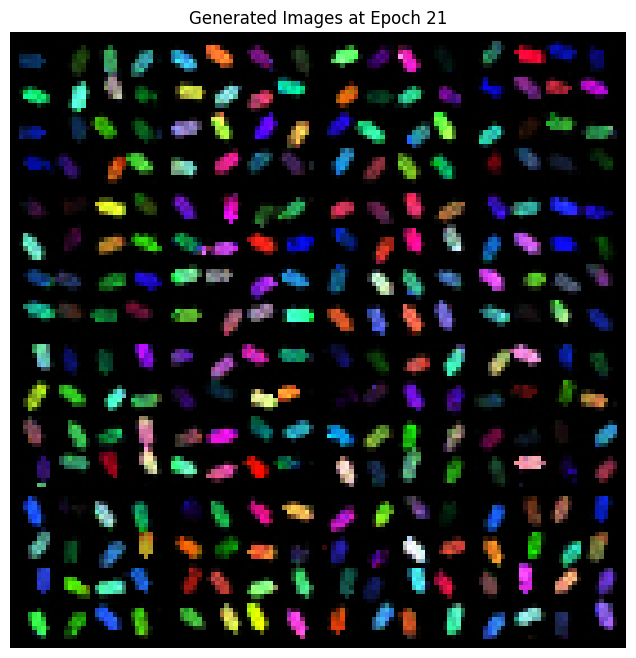

2025-07-07 18:55:19 - INFO - ------------------------------
2025-07-07 18:55:22 - INFO - Epoch: 22/60 | Batch: 0/176 | Loss (NLL): -11838.7051 | BPD: 2.4402
2025-07-07 18:57:02 - INFO - Epoch: 22/60 | Batch: 50/176 | Loss (NLL): -12045.0488 | BPD: 2.3433
2025-07-07 18:58:41 - INFO - Epoch: 22/60 | Batch: 100/176 | Loss (NLL): -11993.0684 | BPD: 2.3677
2025-07-07 19:00:21 - INFO - Epoch: 22/60 | Batch: 150/176 | Loss (NLL): -11623.5518 | BPD: 2.5413
2025-07-07 19:01:10 - INFO - --- Epoch 22 Summary ---
2025-07-07 19:01:10 - INFO - Average Loss: -11864.5922 | Time: 350.92s
2025-07-07 19:01:10 - INFO - Generating sample images...


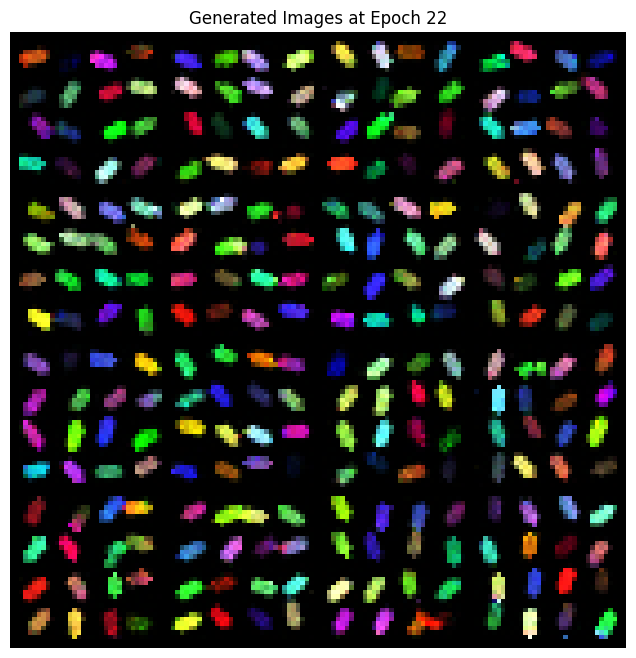

2025-07-07 19:01:10 - INFO - ------------------------------
2025-07-07 19:01:13 - INFO - Epoch: 23/60 | Batch: 0/176 | Loss (NLL): -11909.4004 | BPD: 2.4070
2025-07-07 19:02:52 - INFO - Epoch: 23/60 | Batch: 50/176 | Loss (NLL): -11795.0352 | BPD: 2.4607
2025-07-07 19:04:30 - INFO - Epoch: 23/60 | Batch: 100/176 | Loss (NLL): -11394.1035 | BPD: 2.6490
2025-07-07 19:06:08 - INFO - Epoch: 23/60 | Batch: 150/176 | Loss (NLL): -12028.3789 | BPD: 2.3511
2025-07-07 19:06:56 - INFO - --- Epoch 23 Summary ---
2025-07-07 19:06:56 - INFO - Average Loss: -11970.2328 | Time: 345.84s
2025-07-07 19:06:56 - INFO - Generating sample images...


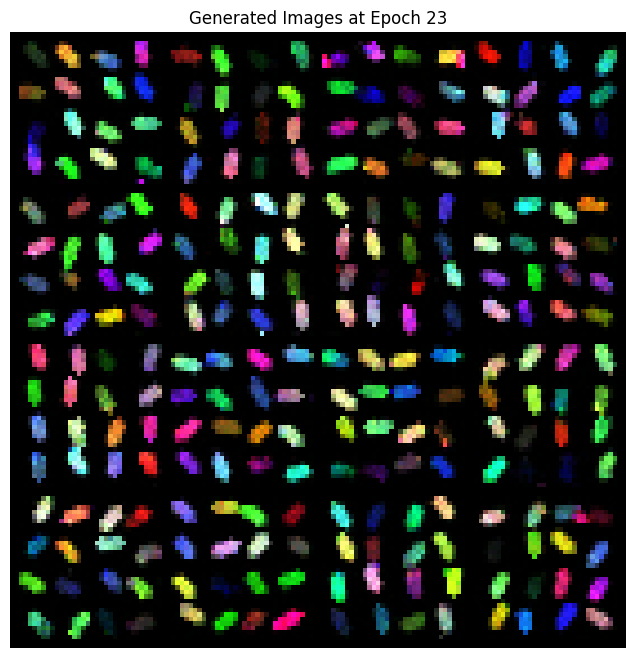

2025-07-07 19:06:57 - INFO - ------------------------------
2025-07-07 19:07:00 - INFO - Epoch: 24/60 | Batch: 0/176 | Loss (NLL): -11472.2012 | BPD: 2.6123
2025-07-07 19:08:38 - INFO - Epoch: 24/60 | Batch: 50/176 | Loss (NLL): -12057.4707 | BPD: 2.3375
2025-07-07 19:10:16 - INFO - Epoch: 24/60 | Batch: 100/176 | Loss (NLL): -11721.9570 | BPD: 2.4950
2025-07-07 19:11:54 - INFO - Epoch: 24/60 | Batch: 150/176 | Loss (NLL): -12004.5684 | BPD: 2.3623
2025-07-07 19:12:42 - INFO - --- Epoch 24 Summary ---
2025-07-07 19:12:42 - INFO - Average Loss: -11928.0645 | Time: 345.56s
2025-07-07 19:12:42 - INFO - Generating sample images...


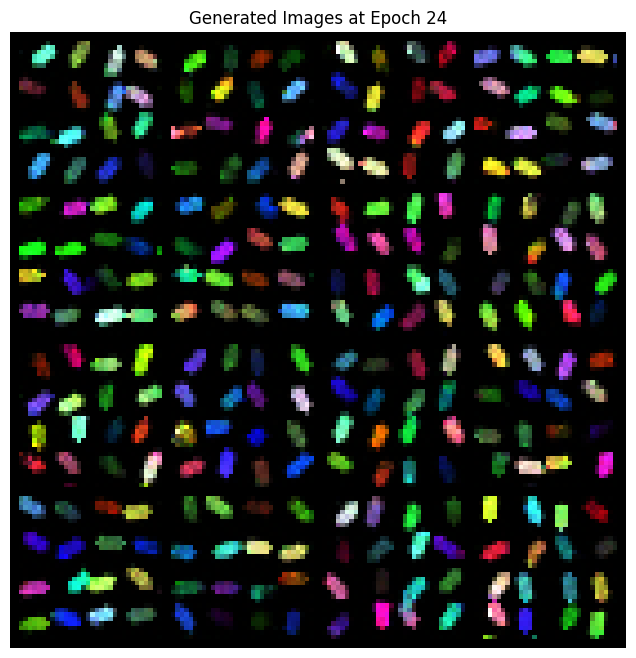

2025-07-07 19:12:43 - INFO - ------------------------------
2025-07-07 19:12:45 - INFO - Epoch: 25/60 | Batch: 0/176 | Loss (NLL): -12060.6660 | BPD: 2.3360
2025-07-07 19:14:24 - INFO - Epoch: 25/60 | Batch: 50/176 | Loss (NLL): -11860.3535 | BPD: 2.4301
2025-07-07 19:16:02 - INFO - Epoch: 25/60 | Batch: 100/176 | Loss (NLL): -12205.6934 | BPD: 2.2679
2025-07-07 19:17:40 - INFO - Epoch: 25/60 | Batch: 150/176 | Loss (NLL): -12054.8096 | BPD: 2.3387
2025-07-07 19:18:29 - INFO - --- Epoch 25 Summary ---
2025-07-07 19:18:29 - INFO - Average Loss: -12028.7064 | Time: 346.50s
2025-07-07 19:18:29 - INFO - Generating sample images...


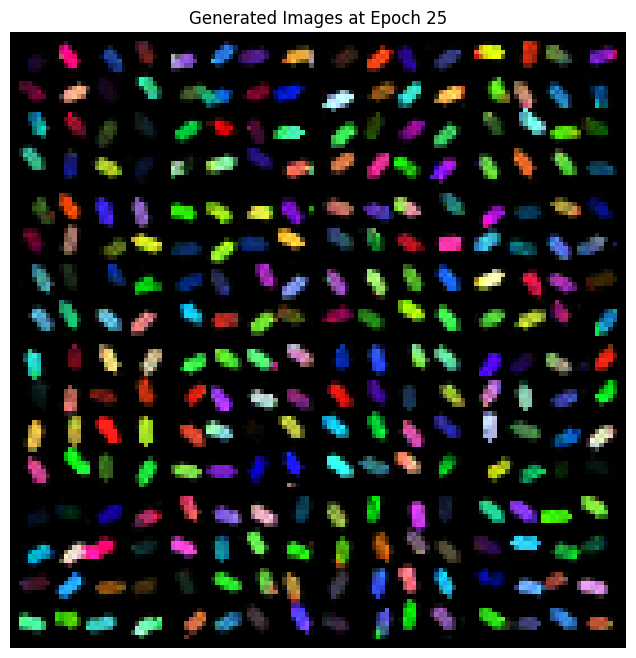

2025-07-07 19:18:30 - INFO - ------------------------------
2025-07-07 19:18:32 - INFO - Epoch: 26/60 | Batch: 0/176 | Loss (NLL): -11841.4326 | BPD: 2.4389
2025-07-07 19:20:10 - INFO - Epoch: 26/60 | Batch: 50/176 | Loss (NLL): -12127.9336 | BPD: 2.3044
2025-07-07 19:21:49 - INFO - Epoch: 26/60 | Batch: 100/176 | Loss (NLL): -11925.9512 | BPD: 2.3992
2025-07-07 19:23:28 - INFO - Epoch: 26/60 | Batch: 150/176 | Loss (NLL): -11871.6611 | BPD: 2.4247
2025-07-07 19:24:17 - INFO - --- Epoch 26 Summary ---
2025-07-07 19:24:17 - INFO - Average Loss: -12070.1317 | Time: 347.55s
2025-07-07 19:24:17 - INFO - Generating sample images...


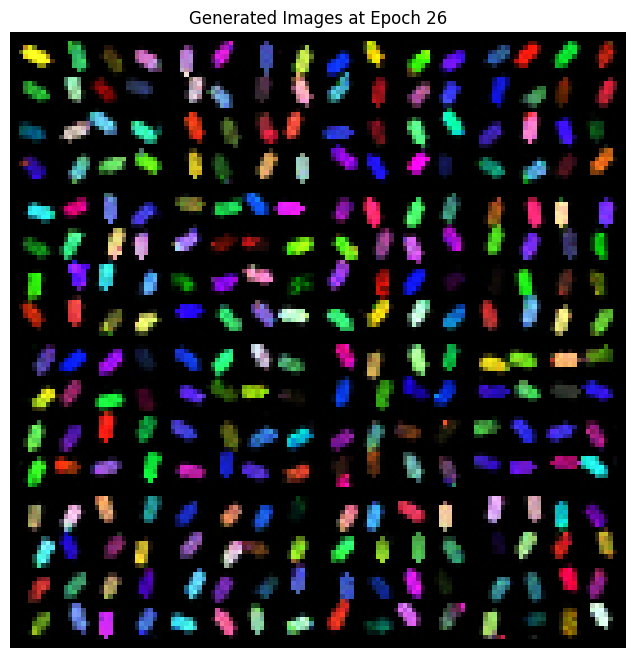

2025-07-07 19:24:18 - INFO - ------------------------------
2025-07-07 19:24:20 - INFO - Epoch: 27/60 | Batch: 0/176 | Loss (NLL): -12069.8916 | BPD: 2.3316
2025-07-07 19:26:00 - INFO - Epoch: 27/60 | Batch: 50/176 | Loss (NLL): -12575.1514 | BPD: 2.0944
2025-07-07 19:27:39 - INFO - Epoch: 27/60 | Batch: 100/176 | Loss (NLL): -12382.5371 | BPD: 2.1848
2025-07-07 19:29:18 - INFO - Epoch: 27/60 | Batch: 150/176 | Loss (NLL): -12130.4980 | BPD: 2.3032
2025-07-07 19:30:07 - INFO - --- Epoch 27 Summary ---
2025-07-07 19:30:07 - INFO - Average Loss: -12150.6086 | Time: 349.56s
2025-07-07 19:30:07 - INFO - Generating sample images...


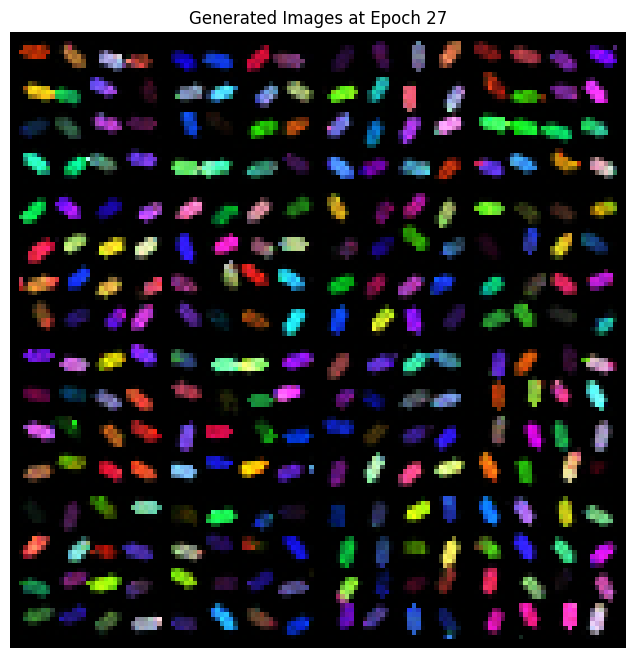

2025-07-07 19:30:08 - INFO - ------------------------------
2025-07-07 19:30:10 - INFO - Epoch: 28/60 | Batch: 0/176 | Loss (NLL): -12255.2266 | BPD: 2.2446
2025-07-07 19:31:50 - INFO - Epoch: 28/60 | Batch: 50/176 | Loss (NLL): -12357.5664 | BPD: 2.1965
2025-07-07 19:33:29 - INFO - Epoch: 28/60 | Batch: 100/176 | Loss (NLL): -11984.0186 | BPD: 2.3720
2025-07-07 19:35:07 - INFO - Epoch: 28/60 | Batch: 150/176 | Loss (NLL): -12061.0303 | BPD: 2.3358
2025-07-07 19:35:57 - INFO - --- Epoch 28 Summary ---
2025-07-07 19:35:57 - INFO - Average Loss: -12104.4695 | Time: 349.75s
2025-07-07 19:35:57 - INFO - Generating sample images...


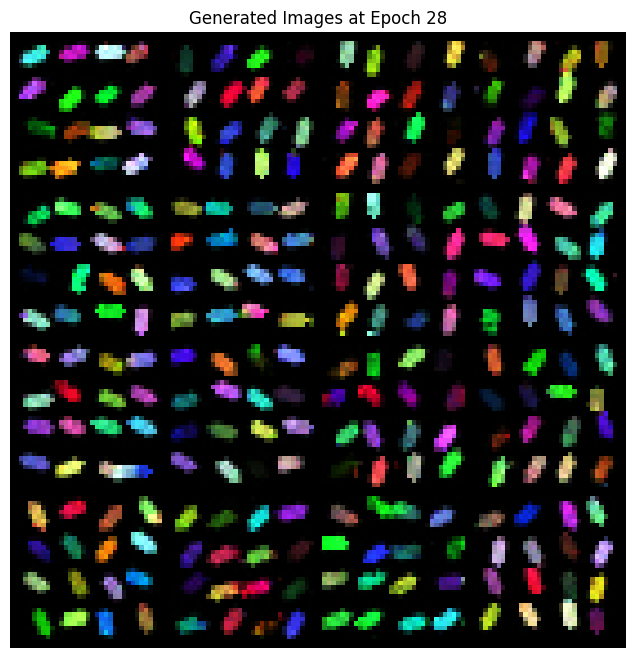

2025-07-07 19:35:58 - INFO - ------------------------------
2025-07-07 19:36:01 - INFO - Epoch: 29/60 | Batch: 0/176 | Loss (NLL): -12319.6338 | BPD: 2.2144
2025-07-07 19:37:40 - INFO - Epoch: 29/60 | Batch: 50/176 | Loss (NLL): -12300.5332 | BPD: 2.2233
2025-07-07 19:39:20 - INFO - Epoch: 29/60 | Batch: 100/176 | Loss (NLL): -12150.4629 | BPD: 2.2938
2025-07-07 19:40:58 - INFO - Epoch: 29/60 | Batch: 150/176 | Loss (NLL): -12221.6934 | BPD: 2.2604
2025-07-07 19:41:48 - INFO - --- Epoch 29 Summary ---
2025-07-07 19:41:48 - INFO - Average Loss: -12184.1838 | Time: 349.69s
2025-07-07 19:41:48 - INFO - Generating sample images...


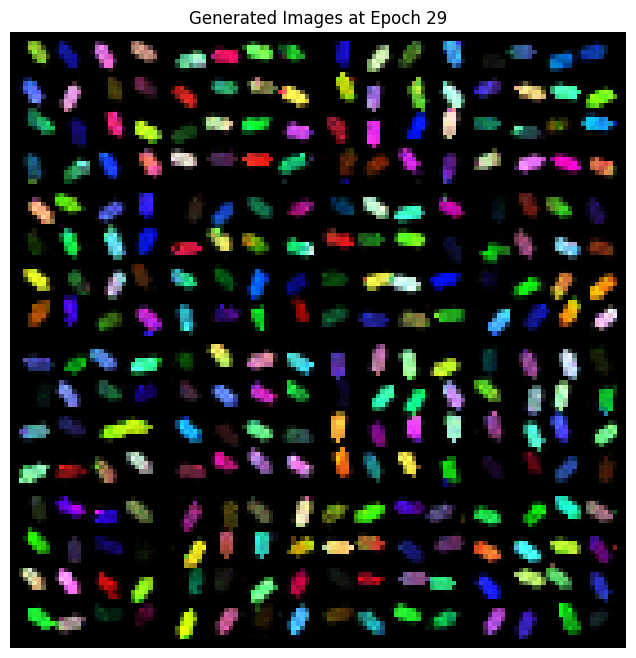

2025-07-07 19:41:48 - INFO - ------------------------------
2025-07-07 19:41:51 - INFO - Epoch: 30/60 | Batch: 0/176 | Loss (NLL): -11889.8652 | BPD: 2.4162
2025-07-07 19:43:29 - INFO - Epoch: 30/60 | Batch: 50/176 | Loss (NLL): -12269.7266 | BPD: 2.2378
2025-07-07 19:45:08 - INFO - Epoch: 30/60 | Batch: 100/176 | Loss (NLL): -12482.1445 | BPD: 2.1380
2025-07-07 19:46:47 - INFO - Epoch: 30/60 | Batch: 150/176 | Loss (NLL): -12023.3887 | BPD: 2.3535
2025-07-07 19:47:36 - INFO - --- Epoch 30 Summary ---
2025-07-07 19:47:36 - INFO - Average Loss: -12274.6307 | Time: 348.34s
2025-07-07 19:47:36 - INFO - Generating sample images...


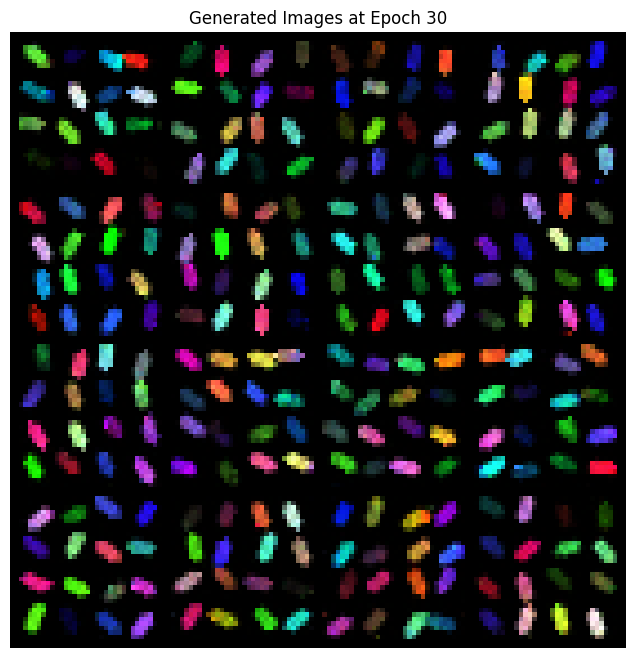

2025-07-07 19:47:37 - INFO - ------------------------------
2025-07-07 19:47:39 - INFO - Epoch: 31/60 | Batch: 0/176 | Loss (NLL): -12452.1699 | BPD: 2.1521
2025-07-07 19:49:18 - INFO - Epoch: 31/60 | Batch: 50/176 | Loss (NLL): -12387.9082 | BPD: 2.1823
2025-07-07 19:50:56 - INFO - Epoch: 31/60 | Batch: 100/176 | Loss (NLL): -12244.2246 | BPD: 2.2498
2025-07-07 19:52:34 - INFO - Epoch: 31/60 | Batch: 150/176 | Loss (NLL): -12389.5469 | BPD: 2.1815
2025-07-07 19:53:23 - INFO - --- Epoch 31 Summary ---
2025-07-07 19:53:23 - INFO - Average Loss: -12283.0331 | Time: 346.32s
2025-07-07 19:53:23 - INFO - Generating sample images...


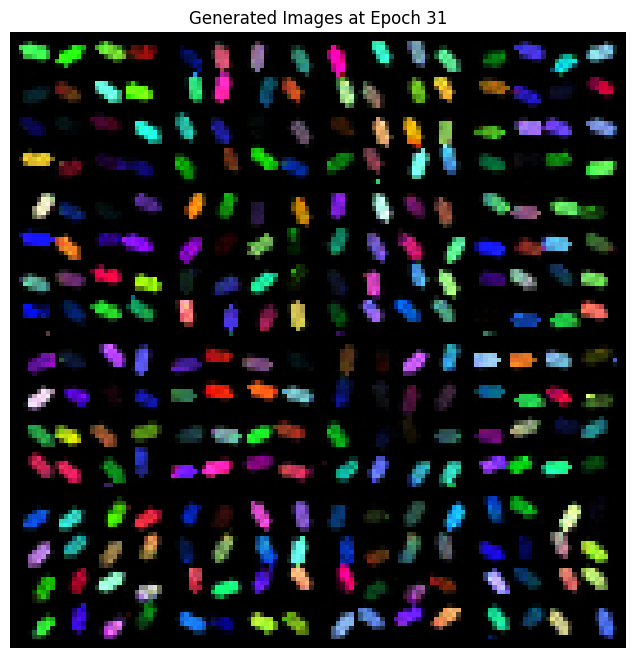

2025-07-07 19:53:23 - INFO - ------------------------------
2025-07-07 19:53:26 - INFO - Epoch: 32/60 | Batch: 0/176 | Loss (NLL): -12462.9316 | BPD: 2.1471
2025-07-07 19:55:04 - INFO - Epoch: 32/60 | Batch: 50/176 | Loss (NLL): -12368.1719 | BPD: 2.1916
2025-07-07 19:56:42 - INFO - Epoch: 32/60 | Batch: 100/176 | Loss (NLL): -12071.6934 | BPD: 2.3308
2025-07-07 19:58:19 - INFO - Epoch: 32/60 | Batch: 150/176 | Loss (NLL): -12520.7178 | BPD: 2.1199
2025-07-07 19:59:08 - INFO - --- Epoch 32 Summary ---
2025-07-07 19:59:08 - INFO - Average Loss: -12348.1014 | Time: 344.40s
2025-07-07 19:59:08 - INFO - Generating sample images...


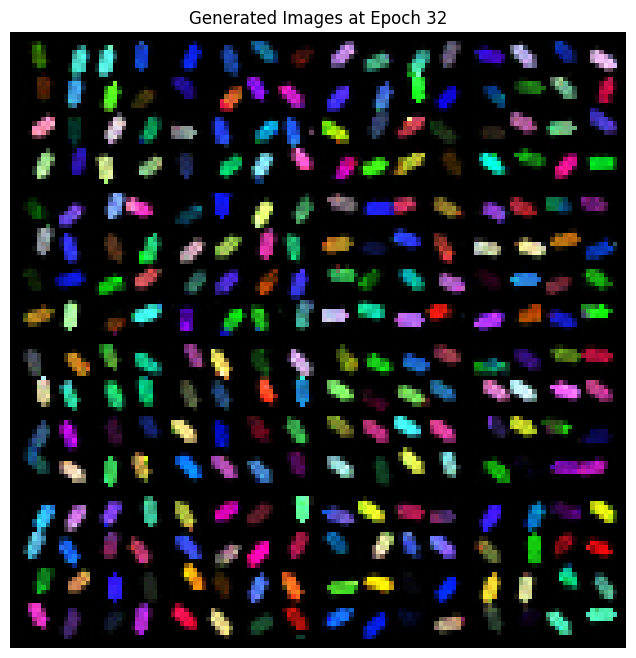

2025-07-07 19:59:08 - INFO - ------------------------------
2025-07-07 19:59:11 - INFO - Epoch: 33/60 | Batch: 0/176 | Loss (NLL): -12350.6055 | BPD: 2.1998
2025-07-07 20:00:50 - INFO - Epoch: 33/60 | Batch: 50/176 | Loss (NLL): -12543.5713 | BPD: 2.1092
2025-07-07 20:02:28 - INFO - Epoch: 33/60 | Batch: 100/176 | Loss (NLL): -12364.1309 | BPD: 2.1935
2025-07-07 20:04:05 - INFO - Epoch: 33/60 | Batch: 150/176 | Loss (NLL): -12534.8018 | BPD: 2.1133
2025-07-07 20:04:54 - INFO - --- Epoch 33 Summary ---
2025-07-07 20:04:54 - INFO - Average Loss: -12406.6376 | Time: 345.67s
2025-07-07 20:04:54 - INFO - Generating sample images...


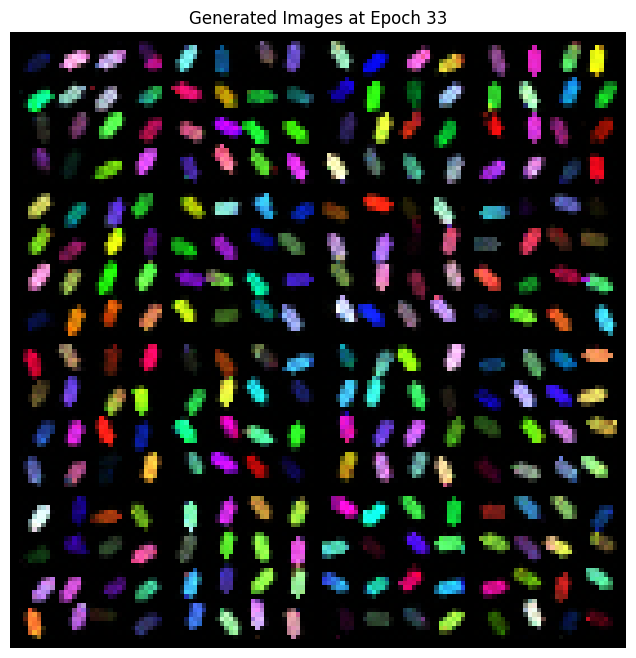

2025-07-07 20:04:54 - INFO - ------------------------------
2025-07-07 20:04:58 - INFO - Epoch: 34/60 | Batch: 0/176 | Loss (NLL): -12135.6387 | BPD: 2.3008
2025-07-07 20:06:36 - INFO - Epoch: 34/60 | Batch: 50/176 | Loss (NLL): -12440.7021 | BPD: 2.1575
2025-07-07 20:08:15 - INFO - Epoch: 34/60 | Batch: 100/176 | Loss (NLL): -12378.8262 | BPD: 2.1866
2025-07-07 20:09:53 - INFO - Epoch: 34/60 | Batch: 150/176 | Loss (NLL): -12647.5869 | BPD: 2.0603
2025-07-07 20:10:42 - INFO - --- Epoch 34 Summary ---
2025-07-07 20:10:42 - INFO - Average Loss: -12460.4521 | Time: 347.80s
2025-07-07 20:10:42 - INFO - Generating sample images...


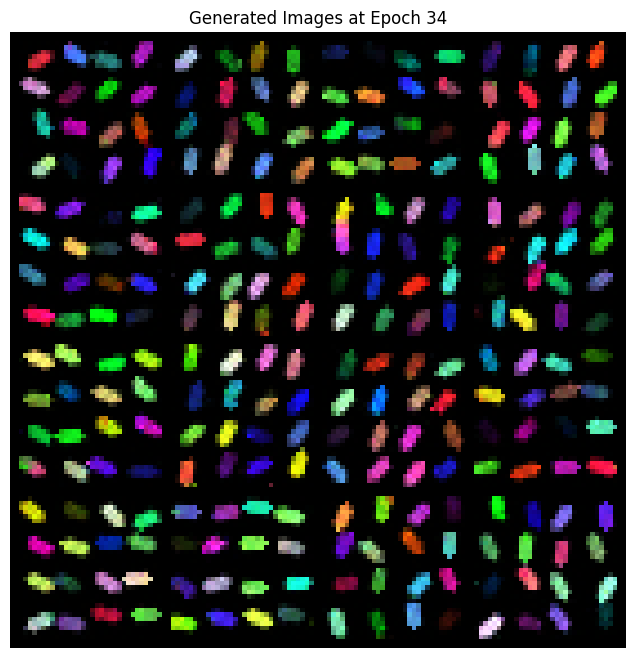

2025-07-07 20:10:43 - INFO - ------------------------------
2025-07-07 20:10:46 - INFO - Epoch: 35/60 | Batch: 0/176 | Loss (NLL): -12414.4932 | BPD: 2.1698
2025-07-07 20:12:24 - INFO - Epoch: 35/60 | Batch: 50/176 | Loss (NLL): -12259.9258 | BPD: 2.2424
2025-07-07 20:14:02 - INFO - Epoch: 35/60 | Batch: 100/176 | Loss (NLL): -12299.9619 | BPD: 2.2236
2025-07-07 20:15:42 - INFO - Epoch: 35/60 | Batch: 150/176 | Loss (NLL): -12646.1045 | BPD: 2.0610
2025-07-07 20:16:31 - INFO - --- Epoch 35 Summary ---
2025-07-07 20:16:31 - INFO - Average Loss: -12421.5788 | Time: 348.25s
2025-07-07 20:16:31 - INFO - Generating sample images...


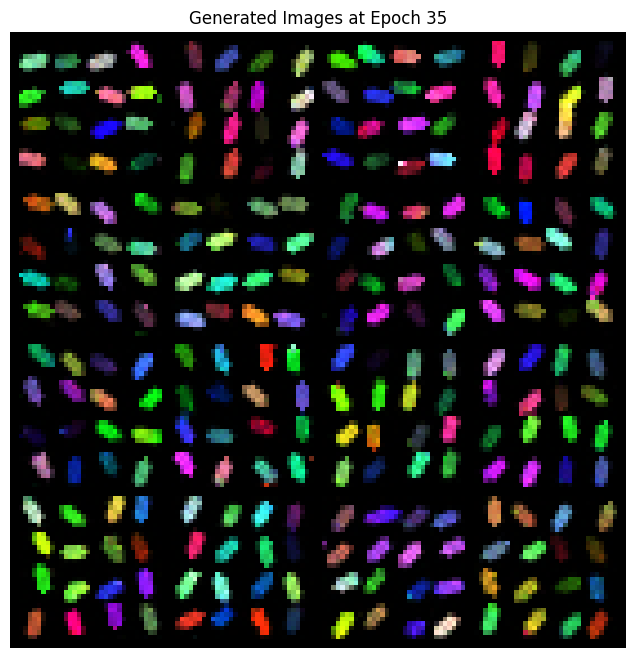

2025-07-07 20:16:31 - INFO - ------------------------------
2025-07-07 20:16:34 - INFO - Epoch: 36/60 | Batch: 0/176 | Loss (NLL): -12461.5996 | BPD: 2.1477
2025-07-07 20:18:14 - INFO - Epoch: 36/60 | Batch: 50/176 | Loss (NLL): -12525.9463 | BPD: 2.1175
2025-07-07 20:19:52 - INFO - Epoch: 36/60 | Batch: 100/176 | Loss (NLL): -12639.4590 | BPD: 2.0642
2025-07-07 20:21:31 - INFO - Epoch: 36/60 | Batch: 150/176 | Loss (NLL): -12786.3623 | BPD: 1.9952
2025-07-07 20:22:20 - INFO - --- Epoch 36 Summary ---
2025-07-07 20:22:20 - INFO - Average Loss: -12514.5827 | Time: 348.54s
2025-07-07 20:22:20 - INFO - Generating sample images...


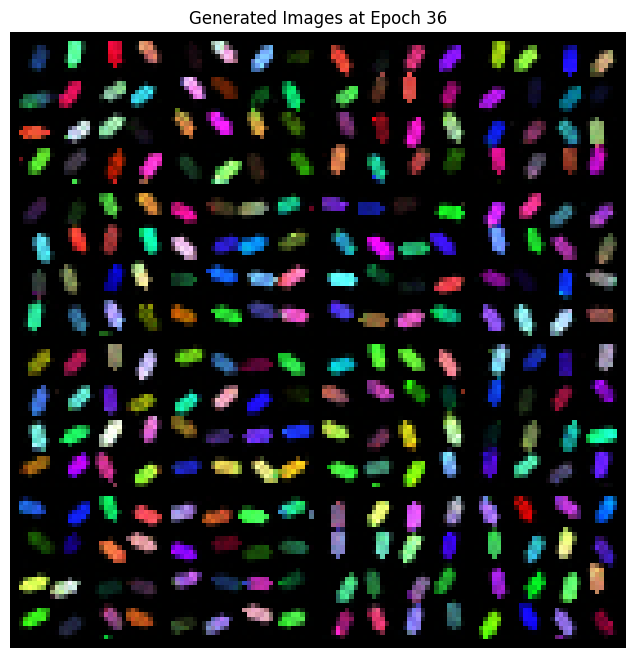

2025-07-07 20:22:20 - INFO - ------------------------------
2025-07-07 20:22:24 - INFO - Epoch: 37/60 | Batch: 0/176 | Loss (NLL): -12531.9688 | BPD: 2.1146
2025-07-07 20:24:02 - INFO - Epoch: 37/60 | Batch: 50/176 | Loss (NLL): -12423.0859 | BPD: 2.1658
2025-07-07 20:25:41 - INFO - Epoch: 37/60 | Batch: 100/176 | Loss (NLL): -12418.8613 | BPD: 2.1678
2025-07-07 20:27:20 - INFO - Epoch: 37/60 | Batch: 150/176 | Loss (NLL): -12609.0020 | BPD: 2.0785
2025-07-07 20:28:09 - INFO - --- Epoch 37 Summary ---
2025-07-07 20:28:09 - INFO - Average Loss: -12521.9501 | Time: 348.53s
2025-07-07 20:28:09 - INFO - Generating sample images...


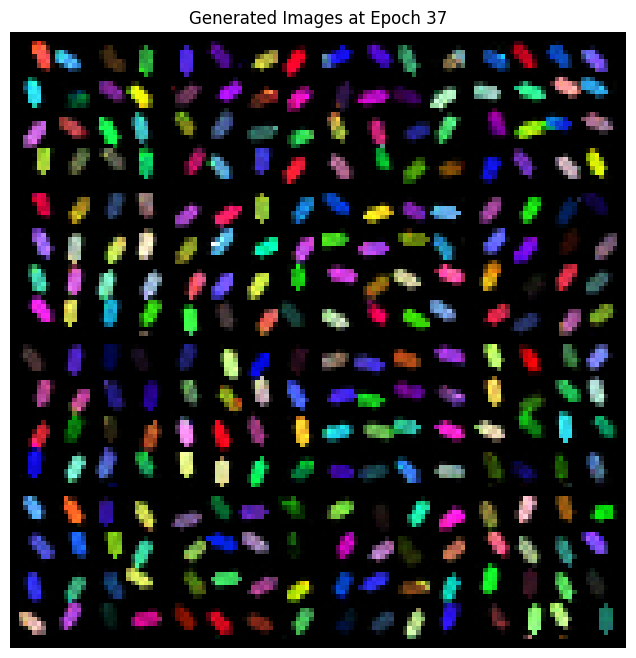

2025-07-07 20:28:09 - INFO - ------------------------------
2025-07-07 20:28:12 - INFO - Epoch: 38/60 | Batch: 0/176 | Loss (NLL): -12526.3154 | BPD: 2.1173
2025-07-07 20:29:51 - INFO - Epoch: 38/60 | Batch: 50/176 | Loss (NLL): -12468.2109 | BPD: 2.1446
2025-07-07 20:31:30 - INFO - Epoch: 38/60 | Batch: 100/176 | Loss (NLL): -12636.5781 | BPD: 2.0655
2025-07-07 20:33:10 - INFO - Epoch: 38/60 | Batch: 150/176 | Loss (NLL): -12758.0684 | BPD: 2.0085
2025-07-07 20:33:59 - INFO - --- Epoch 38 Summary ---
2025-07-07 20:33:59 - INFO - Average Loss: -12607.1744 | Time: 349.84s
2025-07-07 20:33:59 - INFO - Generating sample images...


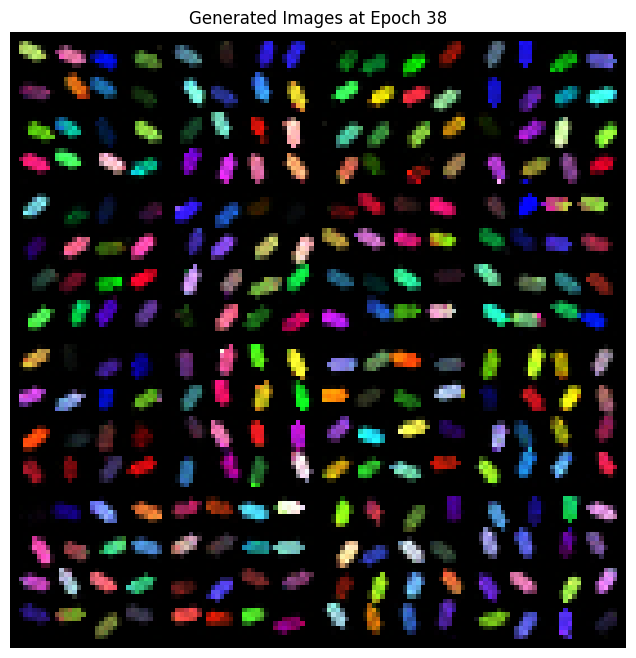

2025-07-07 20:34:00 - INFO - ------------------------------
2025-07-07 20:34:03 - INFO - Epoch: 39/60 | Batch: 0/176 | Loss (NLL): -12719.9219 | BPD: 2.0264
2025-07-07 20:35:41 - INFO - Epoch: 39/60 | Batch: 50/176 | Loss (NLL): -12727.2764 | BPD: 2.0229
2025-07-07 20:37:20 - INFO - Epoch: 39/60 | Batch: 100/176 | Loss (NLL): -12326.5059 | BPD: 2.2111
2025-07-07 20:38:58 - INFO - Epoch: 39/60 | Batch: 150/176 | Loss (NLL): -12666.3262 | BPD: 2.0515
2025-07-07 20:39:47 - INFO - --- Epoch 39 Summary ---
2025-07-07 20:39:47 - INFO - Average Loss: -12587.9984 | Time: 347.81s
2025-07-07 20:39:47 - INFO - Generating sample images...


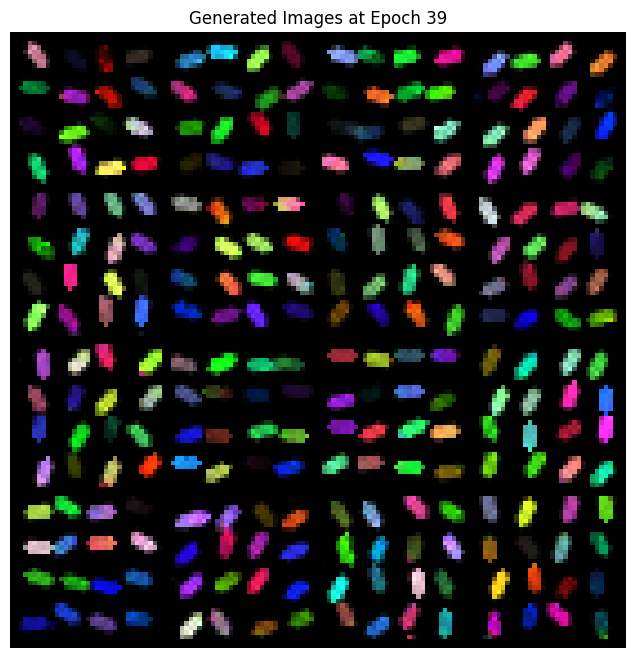

2025-07-07 20:39:48 - INFO - ------------------------------
2025-07-07 20:39:51 - INFO - Epoch: 40/60 | Batch: 0/176 | Loss (NLL): -12809.9141 | BPD: 1.9841
2025-07-07 20:41:29 - INFO - Epoch: 40/60 | Batch: 50/176 | Loss (NLL): -12788.9189 | BPD: 1.9940
2025-07-07 20:43:07 - INFO - Epoch: 40/60 | Batch: 100/176 | Loss (NLL): -12624.1680 | BPD: 2.0713
2025-07-07 20:44:45 - INFO - Epoch: 40/60 | Batch: 150/176 | Loss (NLL): -12723.1523 | BPD: 2.0249
2025-07-07 20:45:34 - INFO - --- Epoch 40 Summary ---
2025-07-07 20:45:34 - INFO - Average Loss: -12690.9246 | Time: 345.79s
2025-07-07 20:45:34 - INFO - Generating sample images...


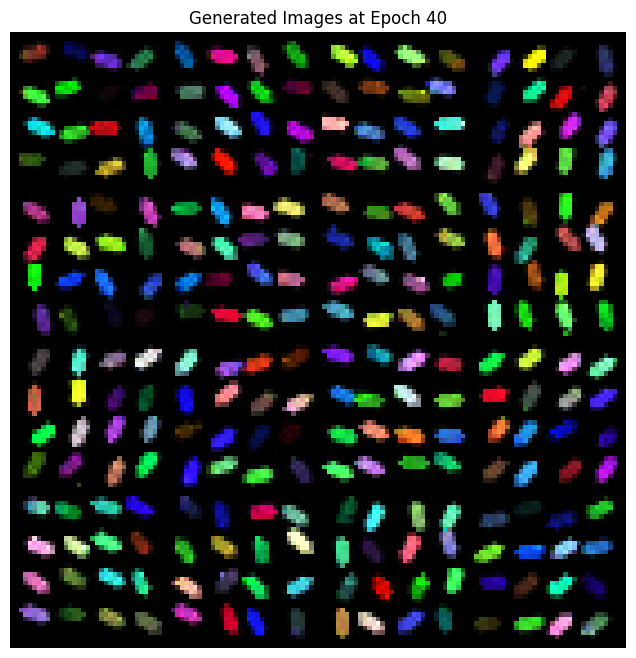

2025-07-07 20:45:34 - INFO - ------------------------------
2025-07-07 20:45:37 - INFO - Epoch: 41/60 | Batch: 0/176 | Loss (NLL): -12188.0957 | BPD: 2.2761
2025-07-07 20:47:15 - INFO - Epoch: 41/60 | Batch: 50/176 | Loss (NLL): -12657.5137 | BPD: 2.0557
2025-07-07 20:48:52 - INFO - Epoch: 41/60 | Batch: 100/176 | Loss (NLL): -12502.7812 | BPD: 2.1284
2025-07-07 20:50:28 - INFO - Epoch: 41/60 | Batch: 150/176 | Loss (NLL): -12823.8164 | BPD: 1.9776
2025-07-07 20:51:17 - INFO - --- Epoch 41 Summary ---
2025-07-07 20:51:17 - INFO - Average Loss: -12676.4494 | Time: 342.44s
2025-07-07 20:51:17 - INFO - Generating sample images...


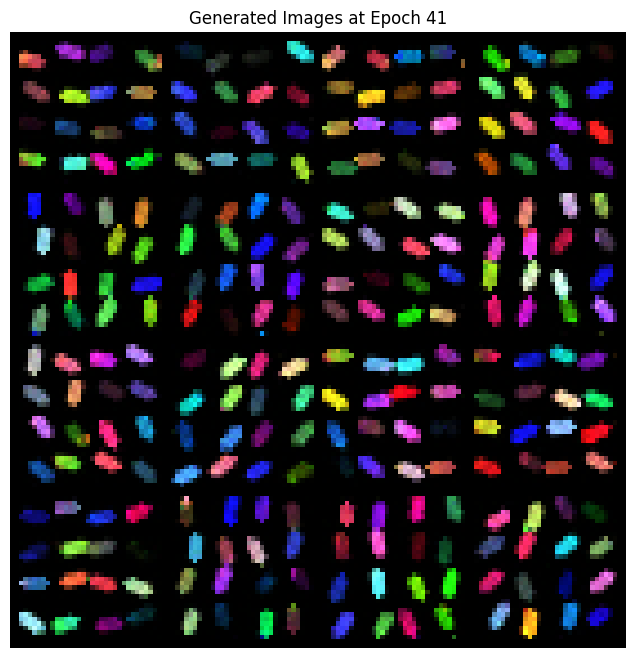

2025-07-07 20:51:17 - INFO - ------------------------------
2025-07-07 20:51:20 - INFO - Epoch: 42/60 | Batch: 0/176 | Loss (NLL): -12392.8994 | BPD: 2.1800
2025-07-07 20:52:57 - INFO - Epoch: 42/60 | Batch: 50/176 | Loss (NLL): -12960.2109 | BPD: 1.9135
2025-07-07 20:54:34 - INFO - Epoch: 42/60 | Batch: 100/176 | Loss (NLL): -12757.6357 | BPD: 2.0087
2025-07-07 20:56:11 - INFO - Epoch: 42/60 | Batch: 150/176 | Loss (NLL): -12661.8154 | BPD: 2.0537
2025-07-07 20:56:59 - INFO - --- Epoch 42 Summary ---
2025-07-07 20:56:59 - INFO - Average Loss: -12650.7866 | Time: 341.79s
2025-07-07 20:56:59 - INFO - Generating sample images...


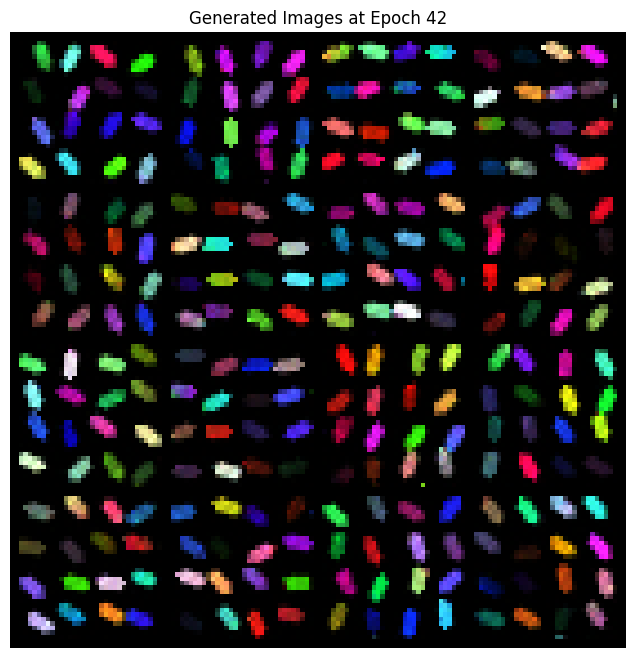

2025-07-07 20:56:59 - INFO - ------------------------------
2025-07-07 20:57:02 - INFO - Epoch: 43/60 | Batch: 0/176 | Loss (NLL): -12906.6523 | BPD: 1.9387
2025-07-07 20:58:39 - INFO - Epoch: 43/60 | Batch: 50/176 | Loss (NLL): -12883.8398 | BPD: 1.9494
2025-07-07 21:00:17 - INFO - Epoch: 43/60 | Batch: 100/176 | Loss (NLL): -12985.3691 | BPD: 1.9017
2025-07-07 21:01:54 - INFO - Epoch: 43/60 | Batch: 150/176 | Loss (NLL): -12827.6777 | BPD: 1.9758
2025-07-07 21:02:43 - INFO - --- Epoch 43 Summary ---
2025-07-07 21:02:43 - INFO - Average Loss: -12784.7052 | Time: 343.36s
2025-07-07 21:02:43 - INFO - Generating sample images...


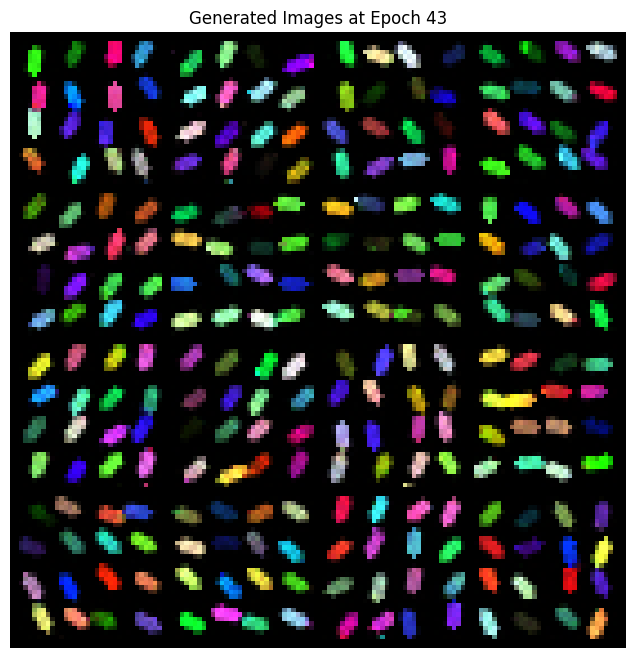

2025-07-07 21:02:43 - INFO - ------------------------------
2025-07-07 21:02:46 - INFO - Epoch: 44/60 | Batch: 0/176 | Loss (NLL): -12712.1191 | BPD: 2.0300
2025-07-07 21:04:26 - INFO - Epoch: 44/60 | Batch: 50/176 | Loss (NLL): -12610.1875 | BPD: 2.0779
2025-07-07 21:06:04 - INFO - Epoch: 44/60 | Batch: 100/176 | Loss (NLL): -12645.1611 | BPD: 2.0615
2025-07-07 21:07:41 - INFO - Epoch: 44/60 | Batch: 150/176 | Loss (NLL): -12902.5879 | BPD: 1.9406
2025-07-07 21:08:29 - INFO - --- Epoch 44 Summary ---
2025-07-07 21:08:29 - INFO - Average Loss: -12748.8753 | Time: 346.37s
2025-07-07 21:08:29 - INFO - Generating sample images...


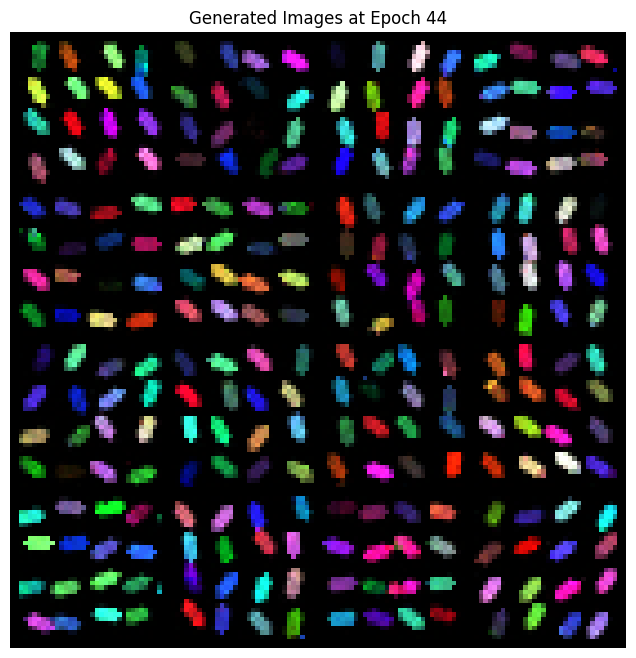

2025-07-07 21:08:30 - INFO - ------------------------------
2025-07-07 21:08:33 - INFO - Epoch: 45/60 | Batch: 0/176 | Loss (NLL): -12862.8105 | BPD: 1.9593
2025-07-07 21:10:10 - INFO - Epoch: 45/60 | Batch: 50/176 | Loss (NLL): -12631.0010 | BPD: 2.0681
2025-07-07 21:11:47 - INFO - Epoch: 45/60 | Batch: 100/176 | Loss (NLL): -12469.5605 | BPD: 2.1440
2025-07-07 21:13:25 - INFO - Epoch: 45/60 | Batch: 150/176 | Loss (NLL): -12452.1553 | BPD: 2.1521
2025-07-07 21:14:13 - INFO - --- Epoch 45 Summary ---
2025-07-07 21:14:13 - INFO - Average Loss: -12755.9666 | Time: 343.32s
2025-07-07 21:14:13 - INFO - Generating sample images...


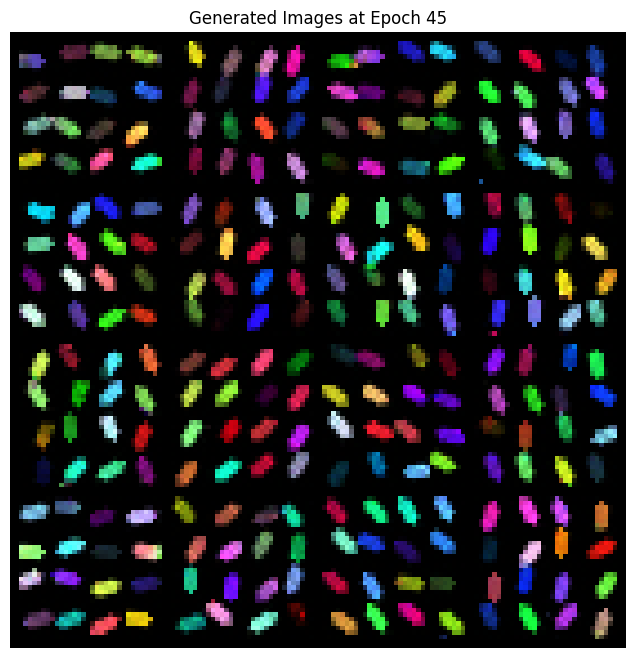

2025-07-07 21:14:14 - INFO - ------------------------------
2025-07-07 21:14:17 - INFO - Epoch: 46/60 | Batch: 0/176 | Loss (NLL): -12823.1260 | BPD: 1.9779
2025-07-07 21:15:55 - INFO - Epoch: 46/60 | Batch: 50/176 | Loss (NLL): -12909.9883 | BPD: 1.9371
2025-07-07 21:17:32 - INFO - Epoch: 46/60 | Batch: 100/176 | Loss (NLL): -12982.5137 | BPD: 1.9031
2025-07-07 21:19:10 - INFO - Epoch: 46/60 | Batch: 150/176 | Loss (NLL): -12840.8438 | BPD: 1.9696
2025-07-07 21:19:58 - INFO - --- Epoch 46 Summary ---
2025-07-07 21:19:58 - INFO - Average Loss: -12811.4083 | Time: 344.93s
2025-07-07 21:19:58 - INFO - Generating sample images...


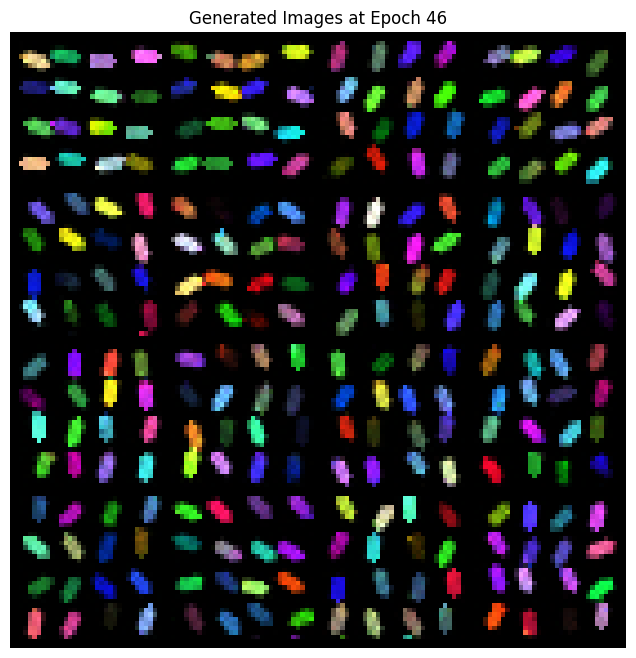

2025-07-07 21:19:59 - INFO - ------------------------------
2025-07-07 21:20:02 - INFO - Epoch: 47/60 | Batch: 0/176 | Loss (NLL): -12846.4062 | BPD: 1.9670
2025-07-07 21:21:39 - INFO - Epoch: 47/60 | Batch: 50/176 | Loss (NLL): -12724.6123 | BPD: 2.0242
2025-07-07 21:23:17 - INFO - Epoch: 47/60 | Batch: 100/176 | Loss (NLL): -12866.3398 | BPD: 1.9576
2025-07-07 21:24:55 - INFO - Epoch: 47/60 | Batch: 150/176 | Loss (NLL): -12791.2676 | BPD: 1.9929
2025-07-07 21:25:43 - INFO - --- Epoch 47 Summary ---
2025-07-07 21:25:43 - INFO - Average Loss: -12854.6738 | Time: 344.22s
2025-07-07 21:25:43 - INFO - Generating sample images...


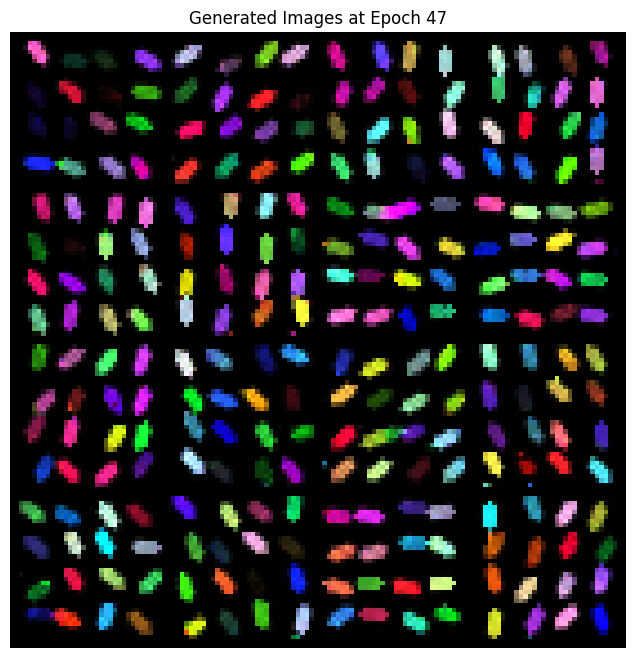

2025-07-07 21:25:44 - INFO - ------------------------------
2025-07-07 21:25:46 - INFO - Epoch: 48/60 | Batch: 0/176 | Loss (NLL): -12773.4141 | BPD: 2.0013
2025-07-07 21:27:24 - INFO - Epoch: 48/60 | Batch: 50/176 | Loss (NLL): -12996.3301 | BPD: 1.8966
2025-07-07 21:29:02 - INFO - Epoch: 48/60 | Batch: 100/176 | Loss (NLL): -12849.4336 | BPD: 1.9656
2025-07-07 21:30:39 - INFO - Epoch: 48/60 | Batch: 150/176 | Loss (NLL): -12574.6348 | BPD: 2.0946
2025-07-07 21:31:28 - INFO - --- Epoch 48 Summary ---
2025-07-07 21:31:28 - INFO - Average Loss: -12862.8398 | Time: 344.05s
2025-07-07 21:31:28 - INFO - Generating sample images...


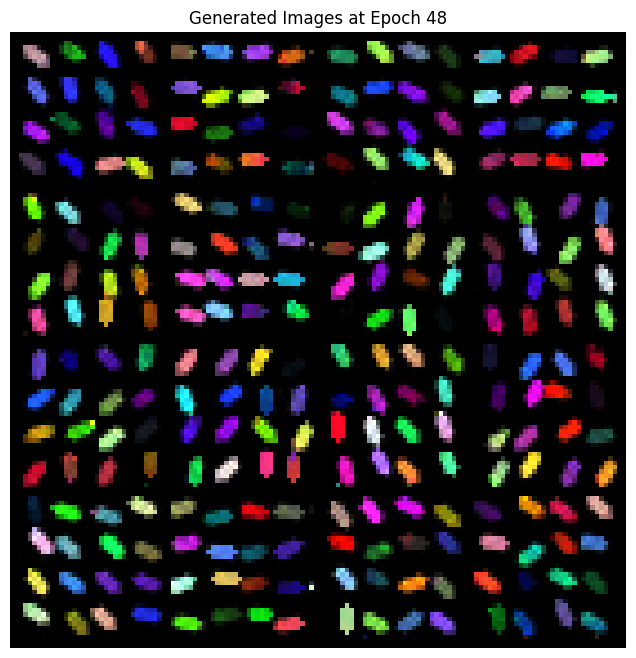

2025-07-07 21:31:28 - INFO - ------------------------------
2025-07-07 21:31:31 - INFO - Epoch: 49/60 | Batch: 0/176 | Loss (NLL): -12709.6230 | BPD: 2.0312
2025-07-07 21:33:08 - INFO - Epoch: 49/60 | Batch: 50/176 | Loss (NLL): -12993.1914 | BPD: 1.8980
2025-07-07 21:34:45 - INFO - Epoch: 49/60 | Batch: 100/176 | Loss (NLL): -12771.1484 | BPD: 2.0023
2025-07-07 21:36:22 - INFO - Epoch: 49/60 | Batch: 150/176 | Loss (NLL): -12780.9365 | BPD: 1.9977
2025-07-07 21:37:11 - INFO - --- Epoch 49 Summary ---
2025-07-07 21:37:11 - INFO - Average Loss: -12931.6342 | Time: 342.99s
2025-07-07 21:37:11 - INFO - Generating sample images...


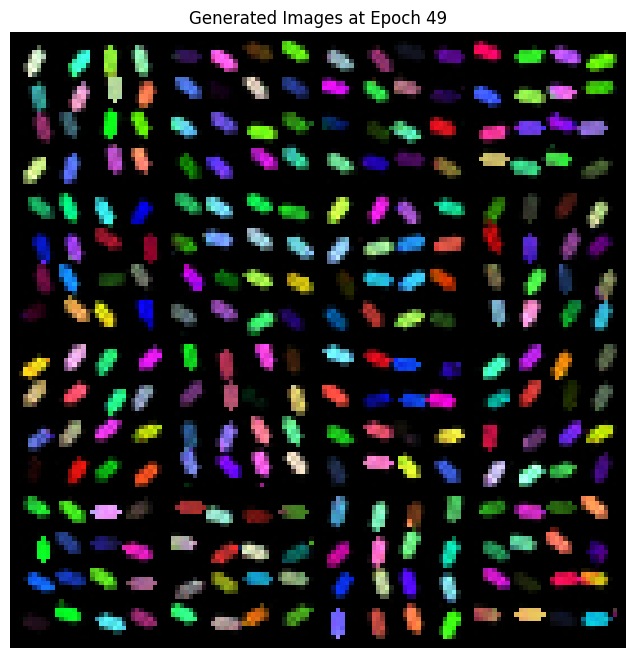

2025-07-07 21:37:11 - INFO - ------------------------------
2025-07-07 21:37:14 - INFO - Epoch: 50/60 | Batch: 0/176 | Loss (NLL): -13019.0488 | BPD: 1.8859
2025-07-07 21:38:52 - INFO - Epoch: 50/60 | Batch: 50/176 | Loss (NLL): -12983.9404 | BPD: 1.9024
2025-07-07 21:40:29 - INFO - Epoch: 50/60 | Batch: 100/176 | Loss (NLL): -12956.1426 | BPD: 1.9154
2025-07-07 21:42:06 - INFO - Epoch: 50/60 | Batch: 150/176 | Loss (NLL): -13037.8496 | BPD: 1.8771
2025-07-07 21:42:54 - INFO - --- Epoch 50 Summary ---
2025-07-07 21:42:54 - INFO - Average Loss: -12972.7674 | Time: 342.91s
2025-07-07 21:42:54 - INFO - Generating sample images...


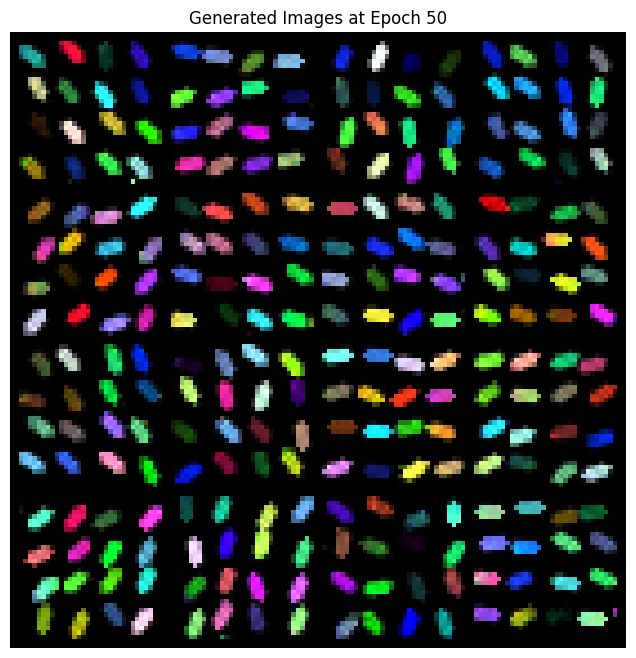

2025-07-07 21:42:55 - INFO - ------------------------------
2025-07-07 21:42:58 - INFO - Epoch: 51/60 | Batch: 0/176 | Loss (NLL): -12810.0400 | BPD: 1.9841
2025-07-07 21:44:35 - INFO - Epoch: 51/60 | Batch: 50/176 | Loss (NLL): -12919.3486 | BPD: 1.9327
2025-07-07 21:46:11 - INFO - Epoch: 51/60 | Batch: 100/176 | Loss (NLL): -13239.2832 | BPD: 1.7825
2025-07-07 21:47:48 - INFO - Epoch: 51/60 | Batch: 150/176 | Loss (NLL): -12821.8965 | BPD: 1.9785
2025-07-07 21:48:36 - INFO - --- Epoch 51 Summary ---
2025-07-07 21:48:36 - INFO - Average Loss: -12940.6833 | Time: 341.63s
2025-07-07 21:48:36 - INFO - Generating sample images...


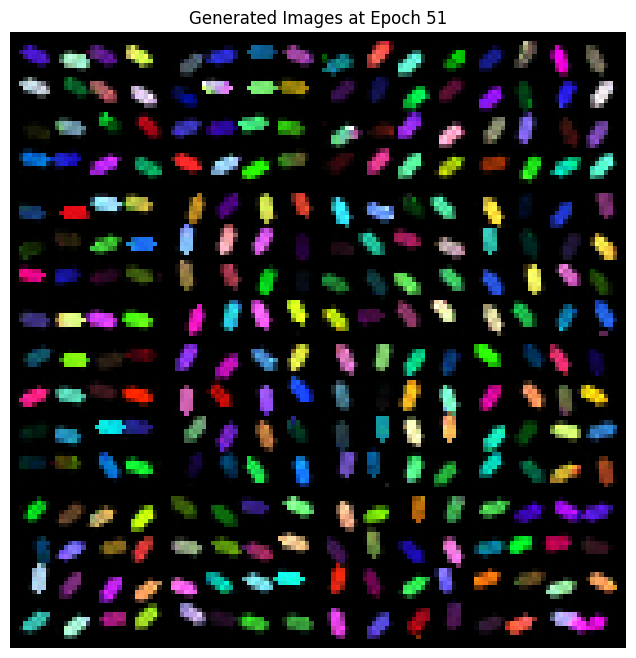

2025-07-07 21:48:37 - INFO - ------------------------------
2025-07-07 21:48:40 - INFO - Epoch: 52/60 | Batch: 0/176 | Loss (NLL): -12791.6475 | BPD: 1.9927
2025-07-07 21:50:16 - INFO - Epoch: 52/60 | Batch: 50/176 | Loss (NLL): -13115.6553 | BPD: 1.8405
2025-07-07 21:51:53 - INFO - Epoch: 52/60 | Batch: 100/176 | Loss (NLL): -12864.6094 | BPD: 1.9584
2025-07-07 21:53:30 - INFO - Epoch: 52/60 | Batch: 150/176 | Loss (NLL): -13093.0996 | BPD: 1.8511
2025-07-07 21:54:19 - INFO - --- Epoch 52 Summary ---
2025-07-07 21:54:19 - INFO - Average Loss: -12952.0903 | Time: 342.06s
2025-07-07 21:54:19 - INFO - Generating sample images...


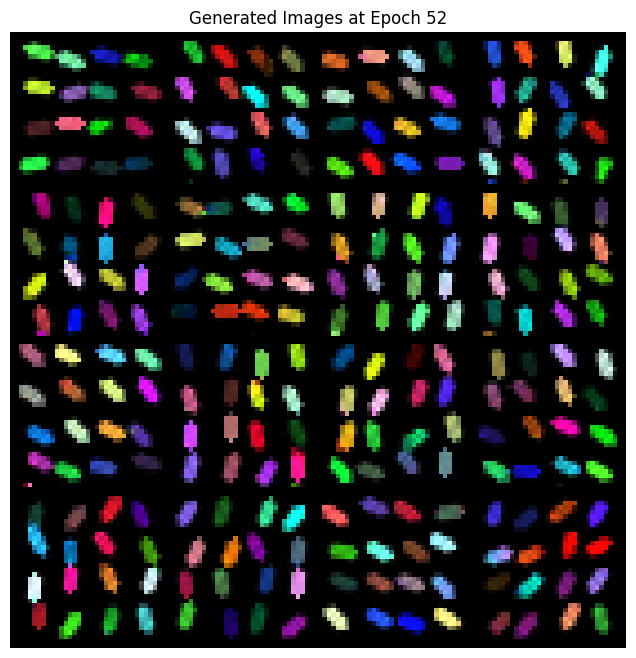

2025-07-07 21:54:19 - INFO - ------------------------------
2025-07-07 21:54:22 - INFO - Epoch: 53/60 | Batch: 0/176 | Loss (NLL): -13206.0195 | BPD: 1.7981
2025-07-07 21:55:59 - INFO - Epoch: 53/60 | Batch: 50/176 | Loss (NLL): -13088.5645 | BPD: 1.8533
2025-07-07 21:57:37 - INFO - Epoch: 53/60 | Batch: 100/176 | Loss (NLL): -12970.8594 | BPD: 1.9085
2025-07-07 21:59:15 - INFO - Epoch: 53/60 | Batch: 150/176 | Loss (NLL): -12953.1865 | BPD: 1.9168
2025-07-07 22:00:03 - INFO - --- Epoch 53 Summary ---
2025-07-07 22:00:03 - INFO - Average Loss: -12997.9914 | Time: 343.68s
2025-07-07 22:00:03 - INFO - Generating sample images...


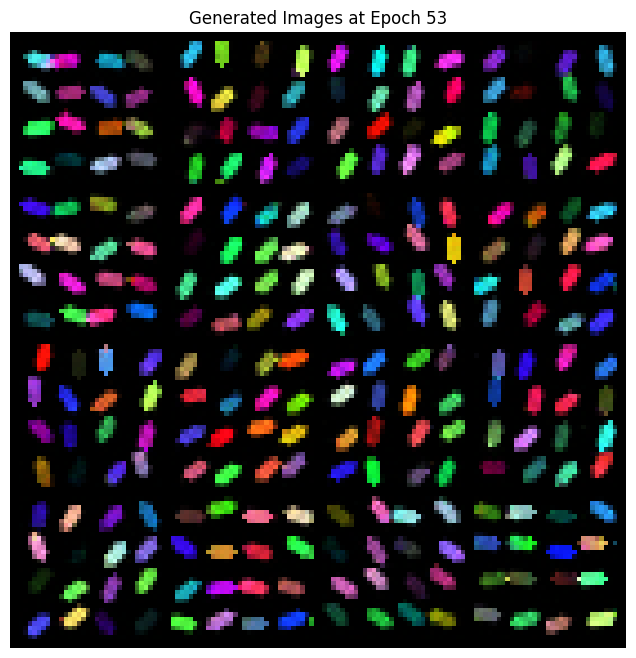

2025-07-07 22:00:04 - INFO - ------------------------------
2025-07-07 22:00:06 - INFO - Epoch: 54/60 | Batch: 0/176 | Loss (NLL): -13076.4082 | BPD: 1.8590
2025-07-07 22:01:44 - INFO - Epoch: 54/60 | Batch: 50/176 | Loss (NLL): -13132.7002 | BPD: 1.8325
2025-07-07 22:03:21 - INFO - Epoch: 54/60 | Batch: 100/176 | Loss (NLL): -13196.1367 | BPD: 1.8027
2025-07-07 22:04:59 - INFO - Epoch: 54/60 | Batch: 150/176 | Loss (NLL): -13267.9443 | BPD: 1.7690
2025-07-07 22:05:47 - INFO - --- Epoch 54 Summary ---
2025-07-07 22:05:47 - INFO - Average Loss: -13041.2042 | Time: 343.47s
2025-07-07 22:05:47 - INFO - Generating sample images...


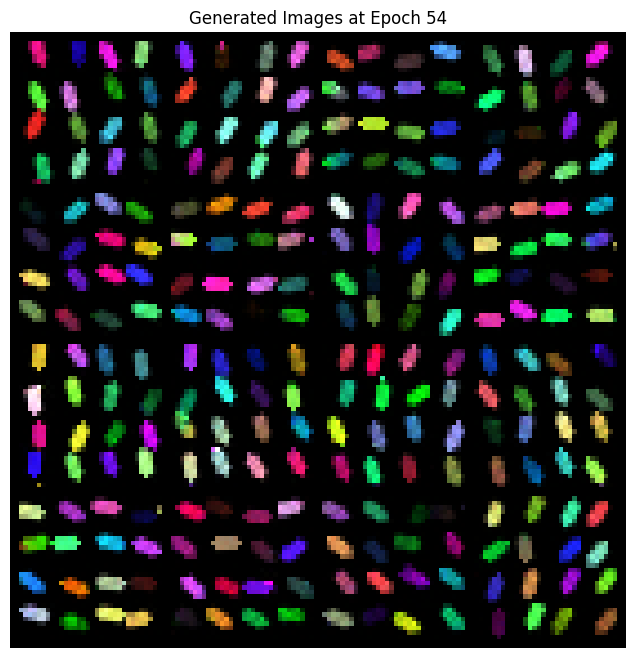

2025-07-07 22:05:47 - INFO - ------------------------------
2025-07-07 22:05:50 - INFO - Epoch: 55/60 | Batch: 0/176 | Loss (NLL): -12869.7285 | BPD: 1.9560
2025-07-07 22:07:27 - INFO - Epoch: 55/60 | Batch: 50/176 | Loss (NLL): -12854.8291 | BPD: 1.9630
2025-07-07 22:09:05 - INFO - Epoch: 55/60 | Batch: 100/176 | Loss (NLL): -13219.1660 | BPD: 1.7919
2025-07-07 22:10:42 - INFO - Epoch: 55/60 | Batch: 150/176 | Loss (NLL): -12579.1367 | BPD: 2.0925
2025-07-07 22:11:31 - INFO - --- Epoch 55 Summary ---
2025-07-07 22:11:31 - INFO - Average Loss: -13000.6076 | Time: 343.72s
2025-07-07 22:11:31 - INFO - Generating sample images...


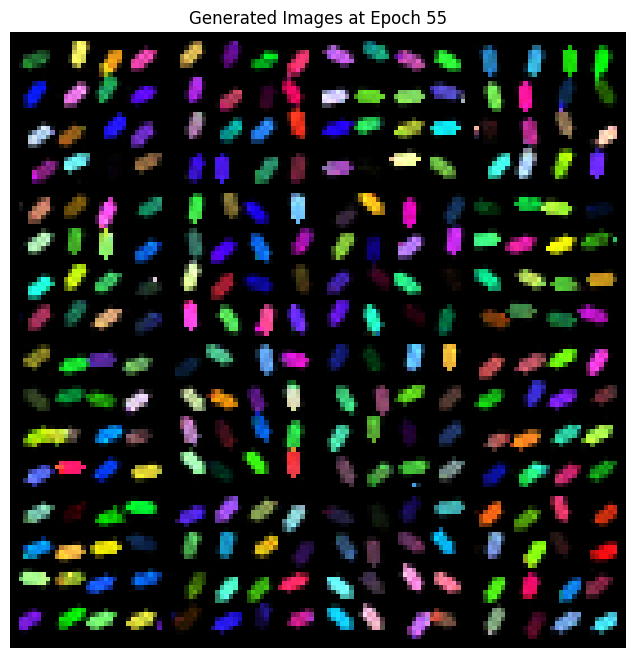

2025-07-07 22:11:32 - INFO - ------------------------------
2025-07-07 22:11:35 - INFO - Epoch: 56/60 | Batch: 0/176 | Loss (NLL): -12746.0166 | BPD: 2.0141
2025-07-07 22:13:12 - INFO - Epoch: 56/60 | Batch: 50/176 | Loss (NLL): -13276.9209 | BPD: 1.7648
2025-07-07 22:14:52 - INFO - Epoch: 56/60 | Batch: 100/176 | Loss (NLL): -13104.8145 | BPD: 1.8456
2025-07-07 22:16:33 - INFO - Epoch: 56/60 | Batch: 150/176 | Loss (NLL): -13106.0137 | BPD: 1.8451
2025-07-07 22:17:23 - INFO - --- Epoch 56 Summary ---
2025-07-07 22:17:23 - INFO - Average Loss: -13054.0066 | Time: 351.87s
2025-07-07 22:17:23 - INFO - Generating sample images...


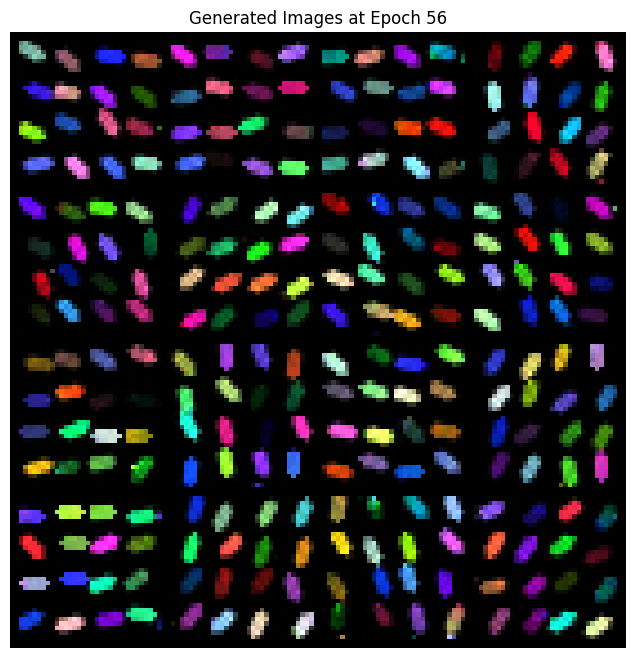

2025-07-07 22:17:24 - INFO - ------------------------------
2025-07-07 22:17:27 - INFO - Epoch: 57/60 | Batch: 0/176 | Loss (NLL): -12837.4580 | BPD: 1.9712
2025-07-07 22:19:08 - INFO - Epoch: 57/60 | Batch: 50/176 | Loss (NLL): -13043.3965 | BPD: 1.8745
2025-07-07 22:20:49 - INFO - Epoch: 57/60 | Batch: 100/176 | Loss (NLL): -13082.2139 | BPD: 1.8562
2025-07-07 22:22:30 - INFO - Epoch: 57/60 | Batch: 150/176 | Loss (NLL): -13101.2480 | BPD: 1.8473
2025-07-07 22:23:21 - INFO - --- Epoch 57 Summary ---
2025-07-07 22:23:21 - INFO - Average Loss: -13078.3553 | Time: 356.90s
2025-07-07 22:23:21 - INFO - Generating sample images...


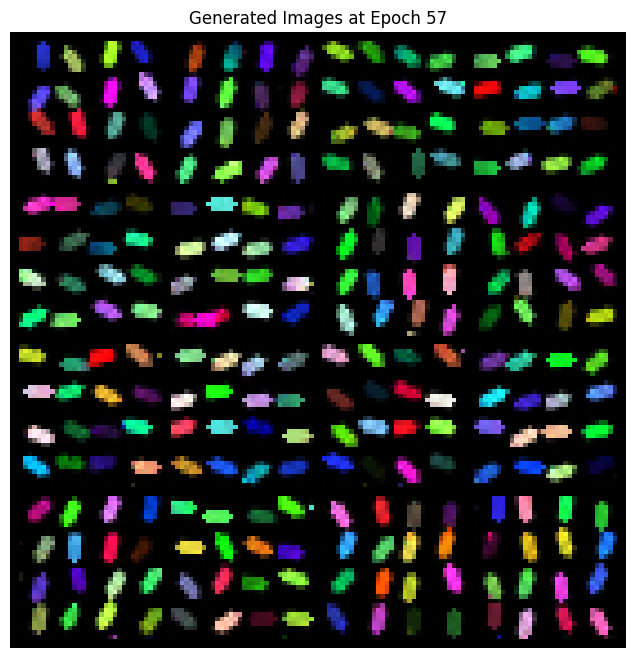

2025-07-07 22:23:21 - INFO - ------------------------------
2025-07-07 22:23:24 - INFO - Epoch: 58/60 | Batch: 0/176 | Loss (NLL): -12946.8066 | BPD: 1.9198
2025-07-07 22:25:06 - INFO - Epoch: 58/60 | Batch: 50/176 | Loss (NLL): -13131.5410 | BPD: 1.8331
2025-07-07 22:26:48 - INFO - Epoch: 58/60 | Batch: 100/176 | Loss (NLL): -13380.0557 | BPD: 1.7164
2025-07-07 22:28:29 - INFO - Epoch: 58/60 | Batch: 150/176 | Loss (NLL): -12892.7051 | BPD: 1.9452
2025-07-07 22:29:18 - INFO - --- Epoch 58 Summary ---
2025-07-07 22:29:18 - INFO - Average Loss: -13065.6370 | Time: 357.20s
2025-07-07 22:29:18 - INFO - Generating sample images...


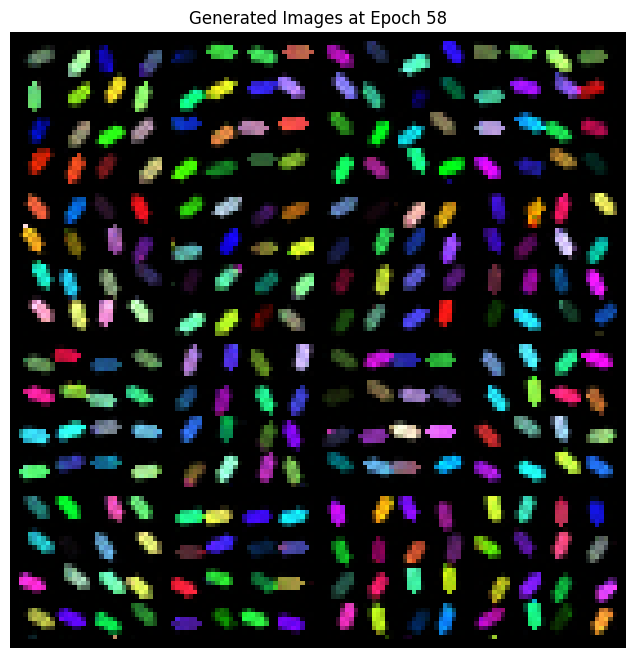

2025-07-07 22:29:19 - INFO - ------------------------------
2025-07-07 22:29:22 - INFO - Epoch: 59/60 | Batch: 0/176 | Loss (NLL): -13139.5859 | BPD: 1.8293
2025-07-07 22:31:01 - INFO - Epoch: 59/60 | Batch: 50/176 | Loss (NLL): -12794.2207 | BPD: 1.9915
2025-07-07 22:32:43 - INFO - Epoch: 59/60 | Batch: 100/176 | Loss (NLL): -13140.0215 | BPD: 1.8291
2025-07-07 22:34:24 - INFO - Epoch: 59/60 | Batch: 150/176 | Loss (NLL): -13053.6934 | BPD: 1.8696
2025-07-07 22:35:15 - INFO - --- Epoch 59 Summary ---
2025-07-07 22:35:15 - INFO - Average Loss: -13132.8920 | Time: 356.06s
2025-07-07 22:35:15 - INFO - Generating sample images...


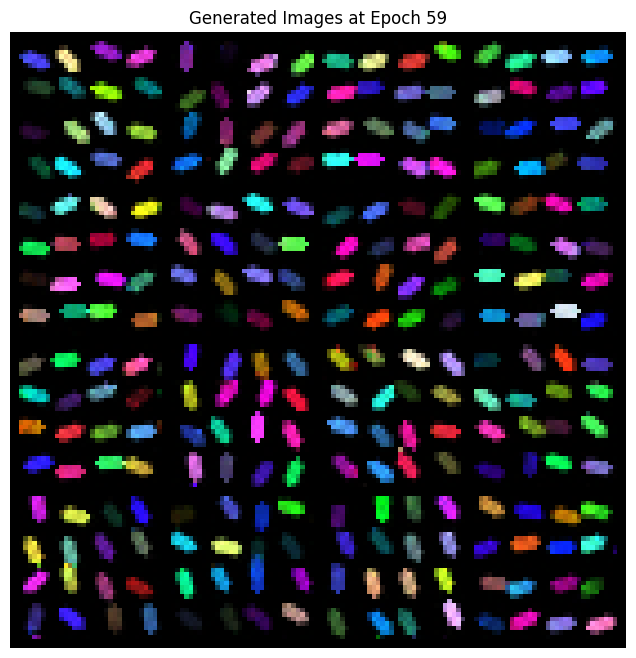

2025-07-07 22:35:15 - INFO - ------------------------------
2025-07-07 22:35:18 - INFO - Epoch: 60/60 | Batch: 0/176 | Loss (NLL): -13098.2969 | BPD: 1.8487
2025-07-07 22:36:59 - INFO - Epoch: 60/60 | Batch: 50/176 | Loss (NLL): -13273.4980 | BPD: 1.7664
2025-07-07 22:38:41 - INFO - Epoch: 60/60 | Batch: 100/176 | Loss (NLL): -13243.5820 | BPD: 1.7805
2025-07-07 22:40:22 - INFO - Epoch: 60/60 | Batch: 150/176 | Loss (NLL): -12891.6250 | BPD: 1.9457
2025-07-07 22:41:11 - INFO - --- Epoch 60 Summary ---
2025-07-07 22:41:11 - INFO - Average Loss: -13091.3509 | Time: 356.09s
2025-07-07 22:41:11 - INFO - Generating sample images...


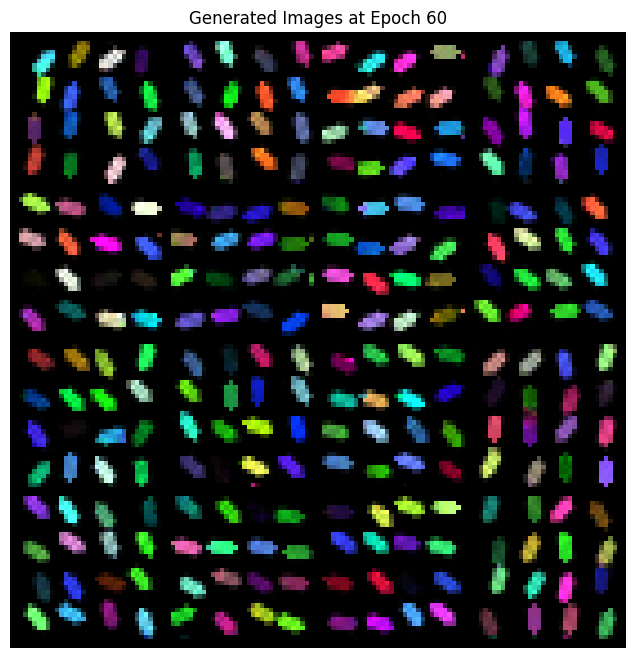

2025-07-07 22:41:12 - INFO - ------------------------------


In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
prior_str = "gaussian"
prior = PriorDistribution(dist_type=prior_str)

logger = setup_logger()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)

try:
    train_rg_flow(
        model=flow,
        prior=prior,
        train_loader=train_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
        logger=logger,
        num_images_to_generate=16
    )
except Exception as e:
    logger.error("An error occurred during training!", exc_info=True)

In [ ]:
from google.colab import files
# Download the generated images directory
!zip -r generated_images.zip generated_images
files.download('generated_images.zip')
# Download the model weights file

  adding: generated_images/ (stored 0%)
  adding: generated_images/epoch_037.png (deflated 9%)
  adding: generated_images/epoch_022.png (deflated 9%)
  adding: generated_images/epoch_051.png (deflated 9%)
  adding: generated_images/epoch_052.png (deflated 9%)
  adding: generated_images/epoch_036.png (deflated 9%)
  adding: generated_images/epoch_043.png (deflated 9%)
  adding: generated_images/epoch_002.png (deflated 9%)
  adding: generated_images/epoch_047.png (deflated 9%)
  adding: generated_images/epoch_028.png (deflated 9%)
  adding: generated_images/epoch_048.png (deflated 9%)
  adding: generated_images/epoch_050.png (deflated 9%)
  adding: generated_images/epoch_029.png (deflated 9%)
  adding: generated_images/epoch_005.png (deflated 9%)
  adding: generated_images/epoch_055.png (deflated 9%)
  adding: generated_images/epoch_040.png (deflated 9%)
  adding: generated_images/epoch_042.png (deflated 9%)
  adding: generated_images/epoch_056.png (deflated 9%)
  adding: generated_image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_WEIGHTS_PATH = f"rg_flow_weights_{timestamp}_{NUM_EPOCHS}_MSD2_{prior_str}.pth"

print(f"Saving model weights to {MODEL_WEIGHTS_PATH}...")

torch.save(flow.state_dict(), MODEL_WEIGHTS_PATH)

print("Model weights saved successfully.")
files.download(MODEL_WEIGHTS_PATH)

Saving model weights to rg_flow_weights_2025-07-07_22-41-12_60_MSD2_gaussian.pth...
Model weights saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer_path = f"rg_flow_optimizer_{timestamp}_{NUM_EPOCHS}_MSD2_{prior_str}.pth"

print(f"Saving optimizer state to {optimizer_path}...")

torch.save(optimizer.state_dict(), optimizer_path)

print("Optimizer state saved successfully.")

files.download(optimizer_path)

Saving optimizer state to rg_flow_optimizer_2025-07-07_22-41-12_60_MSD2_gaussian.pth...
Optimizer state saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>